In [1]:
import numpy as np 
import os 
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from matplotlib import colors 
from matplotlib.ticker import PercentFormatter 

def triangular_plot(chains,save='None'):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(25,25))
    fig.set(facecolor = "white")
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i+1}")
    for i in range(ndim):
        for j in range(i):
            plt.subplot(ndim,ndim,ndim*i+j+1)
            counts,xbins,ybins,image = plt.hist2d(data[:,j],data[:,i],bins=100
                                      ,norm=LogNorm()
                                      , cmap = plt.cm.rainbow)
            plt.colorbar()
            plt.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
            linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
    if save != 'None':
        plt.savefig(save,transparent=False)
        plt.show()
    else: 
        plt.show()

def triangular_plot_slopes(chains,save='None'):
    data=chains.numpy()
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(20,20))
    fig.set(facecolor = "white")
    for i in range(ndim):
        for j in range(i):
            ax=fig.add_subplot(ndim,ndim,ndim*i+j+1)
            #those_slope0=np.extract(np.abs(data[:,0])>0.2,data[:,i]/data[:,j])
            those_slope0=data[:,i]/data[:,j]
            those_slope=np.extract(np.abs(those_slope0)<10,those_slope0)
            ax.hist(those_slope,bins=100)
            ax.set_title(f"x{j+1}/x{i+1}")
            #ax.set_ylabel(f"x{i}")
    if save != 'None':
        plt.savefig(save,transparent=False)
        plt.show()
    else: 
        plt.show()

In [2]:
import tensorflow as tf

# Configuration manuelle du nombre de threads utilisés
tf.config.threading.set_intra_op_parallelism_threads(4)  # Par exemple, 4 threads pour les opérations internes
tf.config.threading.set_inter_op_parallelism_threads(4)  # Par exemple, 4 threads pour les opérations externes


2024-09-26 13:06:30.320714: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [89]:
import numpy as np
import time 

# number of points
n_points = 100000

def V1(x):
    x1,x2,x3,x4=tf.split(x, 4, axis=1)
    return x2**2 - 2*x2*x3 + x3**2 + 2*x2*x4 - 2*x3*x4 + 2*x4**2

def V2(x):
    x1,x2,x3,x4=tf.split(x, 4, axis=1)
    return (x4**2+(x2-x3+x4)**2+(x1+x2+x3+x4)**2)*(x4**2+(x2-x3+x4)**2+1/4*(x1-(-1+np.sqrt(3))*(x2+x3+x4))**2)*(x4**2+(x2-x3+x4)**2+1/4*(x1+(1+np.sqrt(3))*(x2+x3+x4))**2)

def V3(x):
    x1,x2,x3,x4=tf.split(x, 4, axis=1)
    return (x4**2+(x2-x3+x4)**2+(x1+x2+x3+x4)**2)*(x4**2+(x2-x3+x4)**2+1/4*(x1+x2+x3+x4-np.sqrt(3)*(x2+x3+x4)**2)**2)*(x4**2+(x2-x3+x4)**2+1/4*(x1+x2+x3+x4+np.sqrt(3)*(x2+x3+x4)**2)**2)

# compute (||∇V||^2)
def grad_norm_squared(V, x ,factor=1):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)  # compute V at each point
    gradients = tape.gradient(loss, x)  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared * factor

def get_grad(V, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)  # compute V at each point
    gradients = tape.gradient(loss, x)  # compute ∇V at each point
    return gradients


In [6]:
def is_on_axis(x,axis,slope,err):
    """Routine that takes an array of points, and look for those which are close to a given line with slope `slope`
    `x` : array_like. The list of points to analyse
    `axis` : tuple. What axis into which one should like. Ex : look for slope 0.5 between x1 and x2, then axis should be (0,1)
    `slope : float. The value of the slope we are looking at. 
    `err` : float. error.
    
    return : mask of True/False of size x.shape[0] where the point are close to the considered line. """
    these_slopes = x[:,axis[1]]/x[:,axis[0]]
    return np.abs(these_slopes-slope)<err

def is_on_x_squared(x,axis,coef,err):
    """Routine that takes an array of points, and look for those which are close to a given parabol.
    `x` : array_like. The list of points to analyse
    `axis` : tuple. What axis into which one should like. Ex : look for slope 0.5 between x1 and x2, then axis should be (0,1)
    `coef : float. The value of the coefficients in the polynomial : a x**2 + b x + c
    `err` : float. error.
    
    return : mask of True/False of size x.shape[0] where the point are close to the considered parabol. """
    a,b,c=coef
    return np.abs(x[:,axis[0]]-(a*x[:,axis[1]]**2+b*x[:,axis[1]]+c))<err

In [4]:
# V1 Potential 

In [ ]:
# randomly initialize the points
x1 = tf.Variable(np.random.rand(n_points, 4)-2, dtype=tf.float32)

In [5]:
# Oprimizer for the gradient descent

init_alpha=10**(-2)

optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
#optimizer = tf.optimizers.SGD(learning_rate=init_alpha)

# Learning loop 

alpha = init_alpha
update_alpha = False

for step in range(2400):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(V1, x1))  # minimize ||∇V||^2 for all points
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [x1])
      
    #if update_alpha and step % 300 == 0 and step != 0:
    #    alpha = alpha/2
    #    optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    if (not update_alpha) and step % 200 ==0 :
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    if loss.numpy()<10:
        update_alpha = True
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [x1]))
    
    if step % 10 == 0:
        print(f"Step {step}: ||∇V||^2 = {loss.numpy(),alpha}")
        
    if np.log(loss.numpy())/np.log(10)<-6: 
        print("Converged enough") 
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

Step 0: ||∇V||^2 = (5799490.0, 0.01)
Step 10: ||∇V||^2 = (4264168.0, 0.01)
Step 20: ||∇V||^2 = (3035426.0, 0.01)
Step 30: ||∇V||^2 = (2109933.5, 0.01)
Step 40: ||∇V||^2 = (1449561.6, 0.01)
Step 50: ||∇V||^2 = (998536.0, 0.01)
Step 60: ||∇V||^2 = (700700.3, 0.01)
Step 70: ||∇V||^2 = (508938.44, 0.01)
Step 80: ||∇V||^2 = (387696.75, 0.01)
Step 90: ||∇V||^2 = (311894.88, 0.01)
Step 100: ||∇V||^2 = (264635.3, 0.01)
Step 110: ||∇V||^2 = (234911.9, 0.01)
Step 120: ||∇V||^2 = (215747.12, 0.01)
Step 130: ||∇V||^2 = (202820.6, 0.01)
Step 140: ||∇V||^2 = (193514.31, 0.01)
Step 150: ||∇V||^2 = (186274.4, 0.01)
Step 160: ||∇V||^2 = (180197.33, 0.01)
Step 170: ||∇V||^2 = (174768.81, 0.01)
Step 180: ||∇V||^2 = (169702.9, 0.01)
Step 190: ||∇V||^2 = (164845.06, 0.01)
Step 200: ||∇V||^2 = (160114.77, 0.01)
Step 210: ||∇V||^2 = (120556.766, 0.01)
Step 220: ||∇V||^2 = (89257.0, 0.01)
Step 230: ||∇V||^2 = (64452.406, 0.01)
Step 240: ||∇V||^2 = (45575.9, 0.01)
Step 250: ||∇V||^2 = (31675.387, 0.01)
Step 26

In [6]:
optimizer.get_config()

{'name': 'adam',
 'learning_rate': 0.009999999776482582,
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'loss_scale_factor': None,
 'gradient_accumulation_steps': None,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [7]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(tf.reduce_sum(get_grad(V1,x1)**2,axis=1).numpy()>10**(-i))}")


Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 0
Number of points with ||∇V||^2 > 1e-05 : 0
Number of points with ||∇V||^2 > 1e-06 : 0
Number of points with ||∇V||^2 > 1e-07 : 0
Number of points with ||∇V||^2 > 1e-08 : 0
Number of points with ||∇V||^2 > 1e-09 : 0
Number of points with ||∇V||^2 > 1e-10 : 0
Number of points with ||∇V||^2 > 1e-11 : 45754
Number of points with ||∇V||^2 > 1e-12 : 90486
Number of points with ||∇V||^2 > 1e-13 : 99139
Number of points with ||∇V||^2 > 1e-14 : 99618


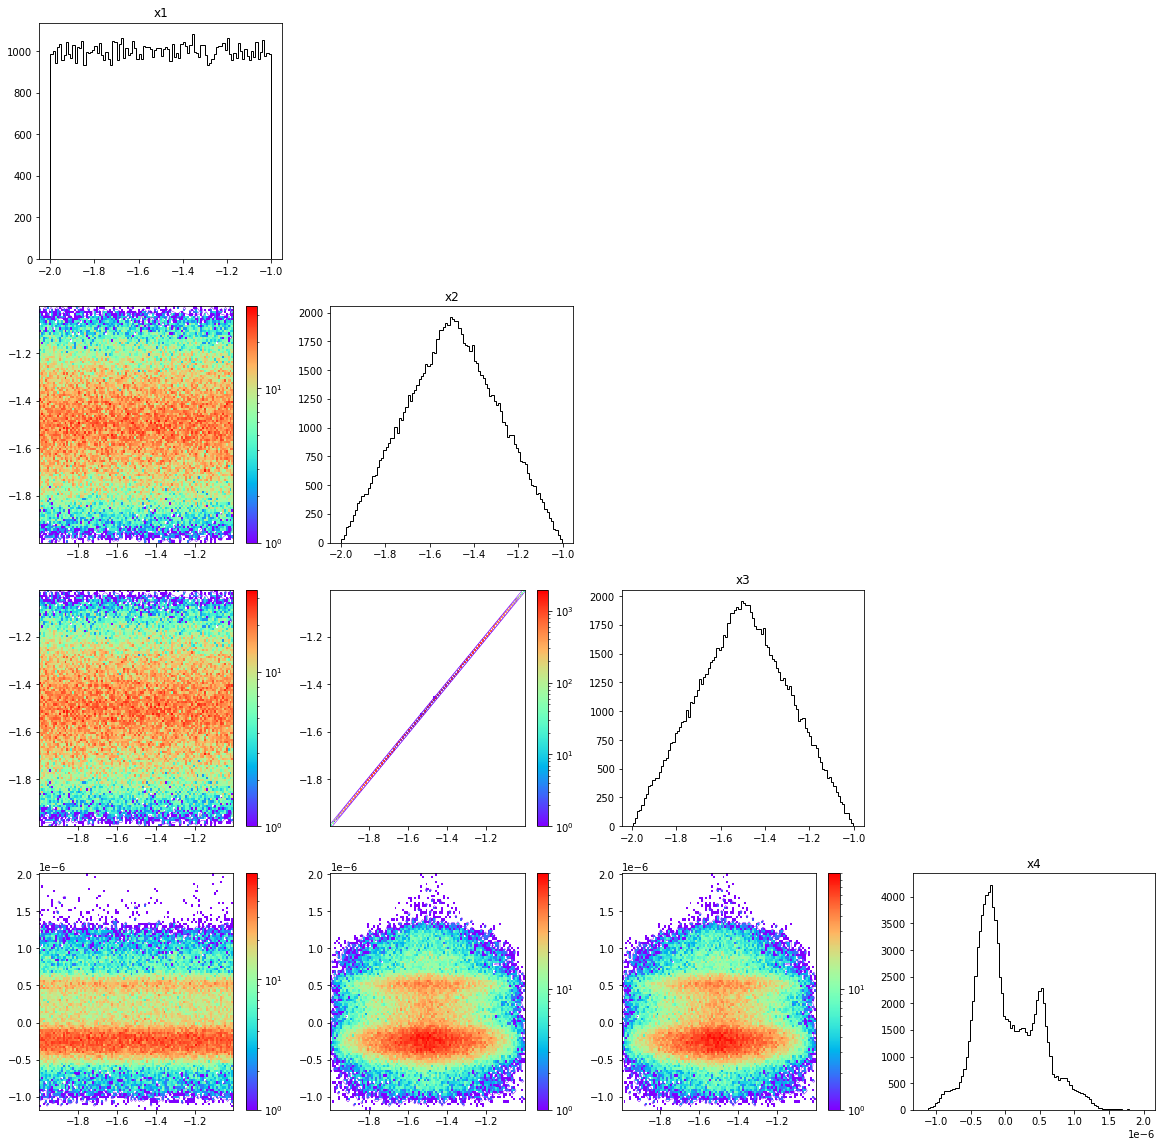

In [10]:
triangular_plot(x1.numpy())

In [10]:
#V2 potential plots and stats

In [11]:
# randomly initialize the points
x2 = tf.Variable(4*np.random.rand(n_points, 4)-2, dtype=tf.float32)

In [12]:
# Oprimizer for the gradient descent

init_alpha=10**(-2)

#optimizer = tf.optimizers.Adam(learning_rate=alpha)
#optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
optimizer = tf.optimizers.SGD(learning_rate=init_alpha)

# Learning loop 

alpha = init_alpha
update_alpha = False
update_opt = True 
for step in range(2400):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(V2, x2))  # minimize ||∇V||^2 for all points
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [x2])
      
    if update_alpha and step % 300 == 0 and step != 0:
        alpha = alpha/2
        optimizer = tf.optimizers.Adam(learning_rate=alpha)
    if update_opt and step % 200 ==0 :
        print("Reinitializing the optimizer")
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    if loss.numpy()<10 and update_opt:
        update_alpha = True
        update_opt = False
        print("Turning update_alpha to True and update_opt to False")
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [x2]))
    
    if step % 10 == 0:
        print(f"Step {step}: ||∇V||^2 = {loss.numpy(),alpha}")
        
    if np.log(loss.numpy())/np.log(10)<-6: 
        print("Converged enough") 
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

Reinitializing the optimizer
Step 0: ||∇V||^2 = (21634205000000.0, 0.01)
Step 10: ||∇V||^2 = (11335853000000.0, 0.01)
Step 20: ||∇V||^2 = (6243522400000.0, 0.01)
Step 30: ||∇V||^2 = (3779234400000.0, 0.01)
Step 40: ||∇V||^2 = (2525126700000.0, 0.01)
Step 50: ||∇V||^2 = (1830230300000.0, 0.01)
Step 60: ||∇V||^2 = (1408184000000.0, 0.01)
Step 70: ||∇V||^2 = (1129803700000.0, 0.01)
Step 80: ||∇V||^2 = (933525300000.0, 0.01)
Step 90: ||∇V||^2 = (787955000000.0, 0.01)
Step 100: ||∇V||^2 = (675875500000.0, 0.01)
Step 110: ||∇V||^2 = (587144760000.0, 0.01)
Step 120: ||∇V||^2 = (515388200000.0, 0.01)
Step 130: ||∇V||^2 = (456373960000.0, 0.01)
Step 140: ||∇V||^2 = (407166200000.0, 0.01)
Step 150: ||∇V||^2 = (365656540000.0, 0.01)
Step 160: ||∇V||^2 = (330288820000.0, 0.01)
Step 170: ||∇V||^2 = (299889230000.0, 0.01)
Step 180: ||∇V||^2 = (273555960000.0, 0.01)
Step 190: ||∇V||^2 = (250585740000.0, 0.01)
Reinitializing the optimizer
Step 200: ||∇V||^2 = (230422740000.0, 0.01)
Step 210: ||∇V||^2 

Step 1920: ||∇V||^2 = (0.11266887, 0.00125)
Step 1930: ||∇V||^2 = (0.013426849, 0.00125)
Step 1940: ||∇V||^2 = (0.01600083, 0.00125)
Step 1950: ||∇V||^2 = (0.0009713025, 0.00125)
Step 1960: ||∇V||^2 = (0.0016155853, 0.00125)
Step 1970: ||∇V||^2 = (0.00078547554, 0.00125)
Step 1980: ||∇V||^2 = (0.00017622052, 0.00125)
Step 1990: ||∇V||^2 = (7.837644e-05, 0.00125)
Step 2000: ||∇V||^2 = (5.148015e-05, 0.00125)
Step 2010: ||∇V||^2 = (5.940114e-05, 0.00125)
Step 2020: ||∇V||^2 = (4.978305e-05, 0.00125)
Step 2030: ||∇V||^2 = (2.1687465e-05, 0.00125)
Step 2040: ||∇V||^2 = (1.3881013e-05, 0.00125)
Step 2050: ||∇V||^2 = (8.884615e-05, 0.00125)
Step 2060: ||∇V||^2 = (0.00016398948, 0.00125)
Step 2070: ||∇V||^2 = (0.00027029376, 0.00125)
Step 2080: ||∇V||^2 = (0.00018701373, 0.00125)
Step 2090: ||∇V||^2 = (4.550517e-05, 0.00125)
Step 2100: ||∇V||^2 = (5.3719315e-05, 0.000625)
Step 2110: ||∇V||^2 = (2386.296, 0.000625)
Step 2120: ||∇V||^2 = (482.39914, 0.000625)
Step 2130: ||∇V||^2 = (22.980526, 0

In [13]:
for i in range(10):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(tf.reduce_sum(get_grad(V2,x2)**2,axis=1).numpy()>10**(-i))}")


Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 0
Number of points with ||∇V||^2 > 1e-05 : 0
Number of points with ||∇V||^2 > 1e-06 : 1
Number of points with ||∇V||^2 > 1e-07 : 7
Number of points with ||∇V||^2 > 1e-08 : 35
Number of points with ||∇V||^2 > 1e-09 : 303


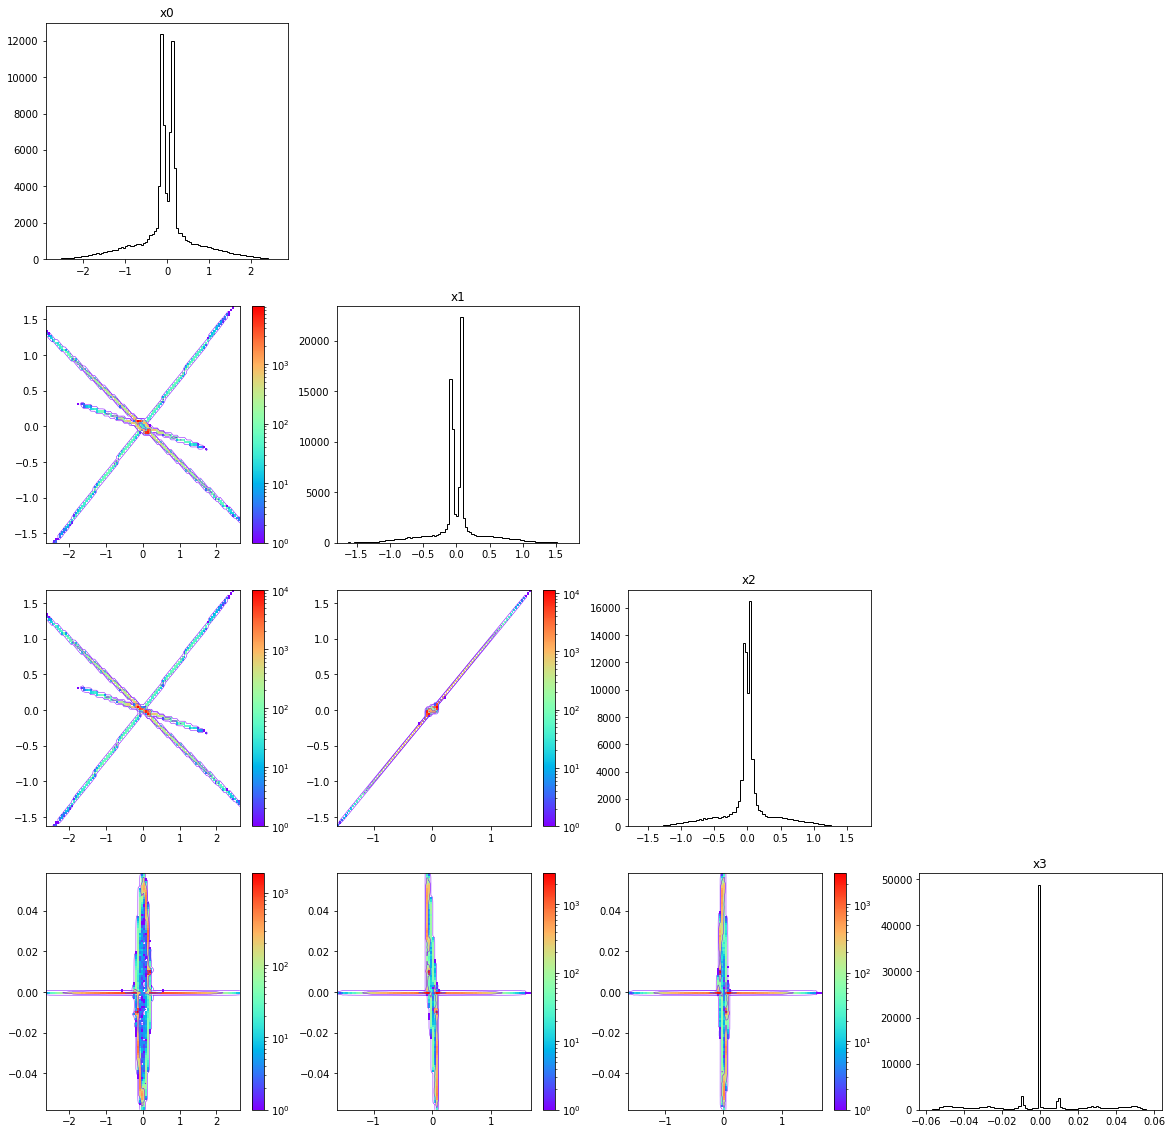

In [14]:
triangular_plot(x2.numpy())

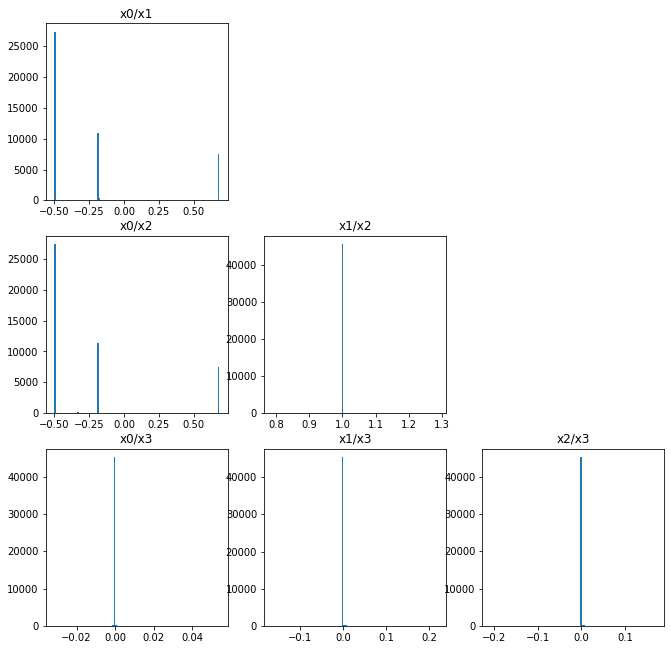

In [15]:
# compute what are the different slopes in the data
triangular_plot_slopes(x2)

In [16]:
# to be compared with the values 
print(1/(-2*(1-np.sqrt(3))))
print(1/(-2*(1+np.sqrt(3))))

0.6830127018922194
-0.18301270189221933


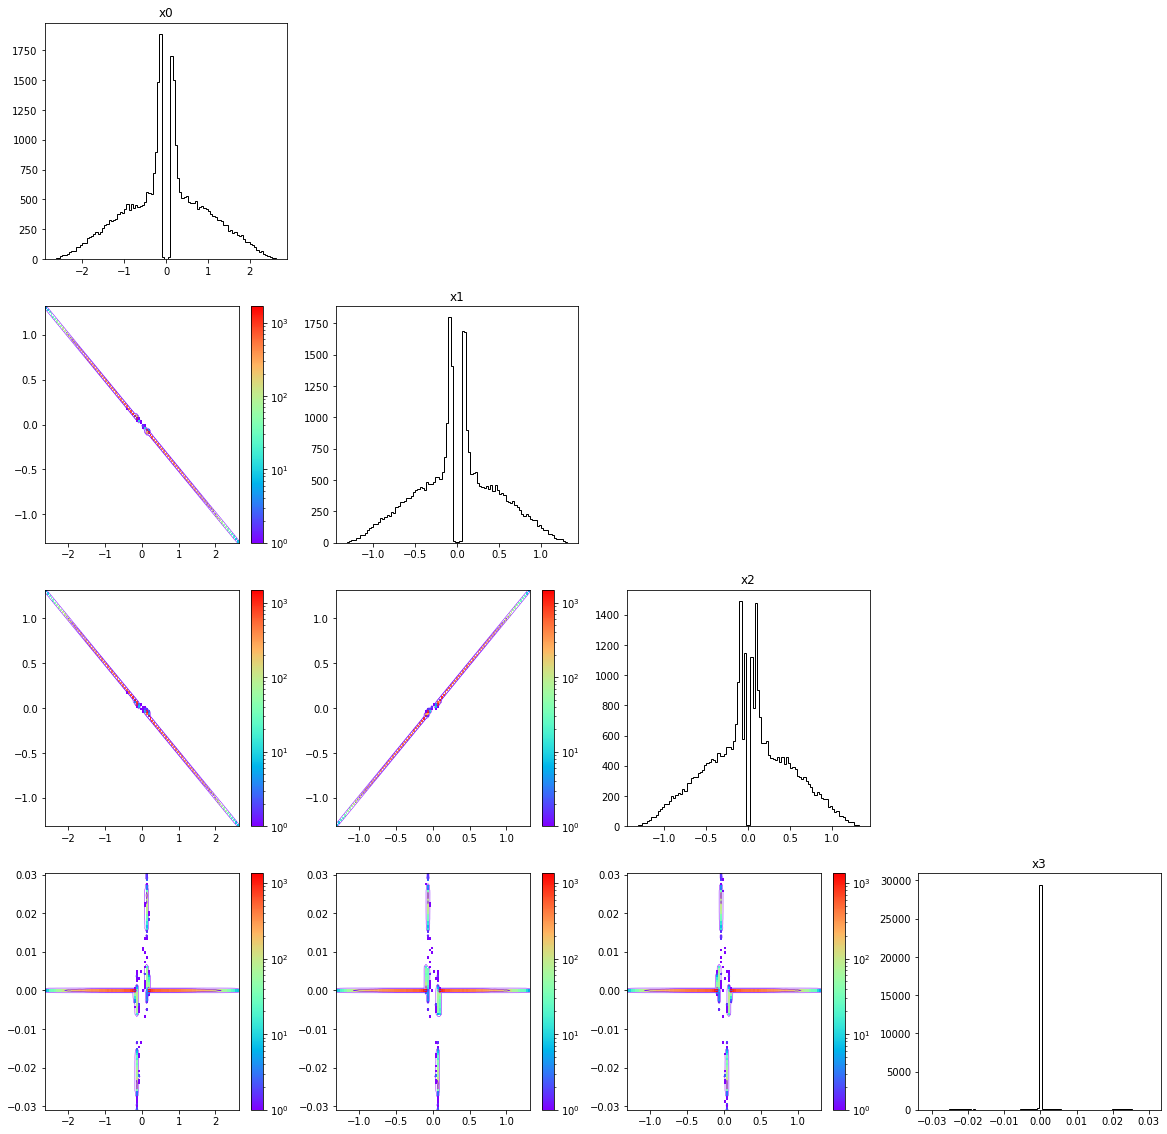

In [22]:
#Extract the point that have x1 = -0.5 x0 
mask_points=is_on_axis(x2.numpy(),(0,1),-0.5,0.05)
points=np.transpose(np.array([np.extract(mask_points,x2[:,0].numpy()),np.extract(mask_points,x2[:,1].numpy()),np.extract(mask_points,x2[:,2].numpy()),np.extract(mask_points,x2[:,3].numpy())]))
triangular_plot(points)


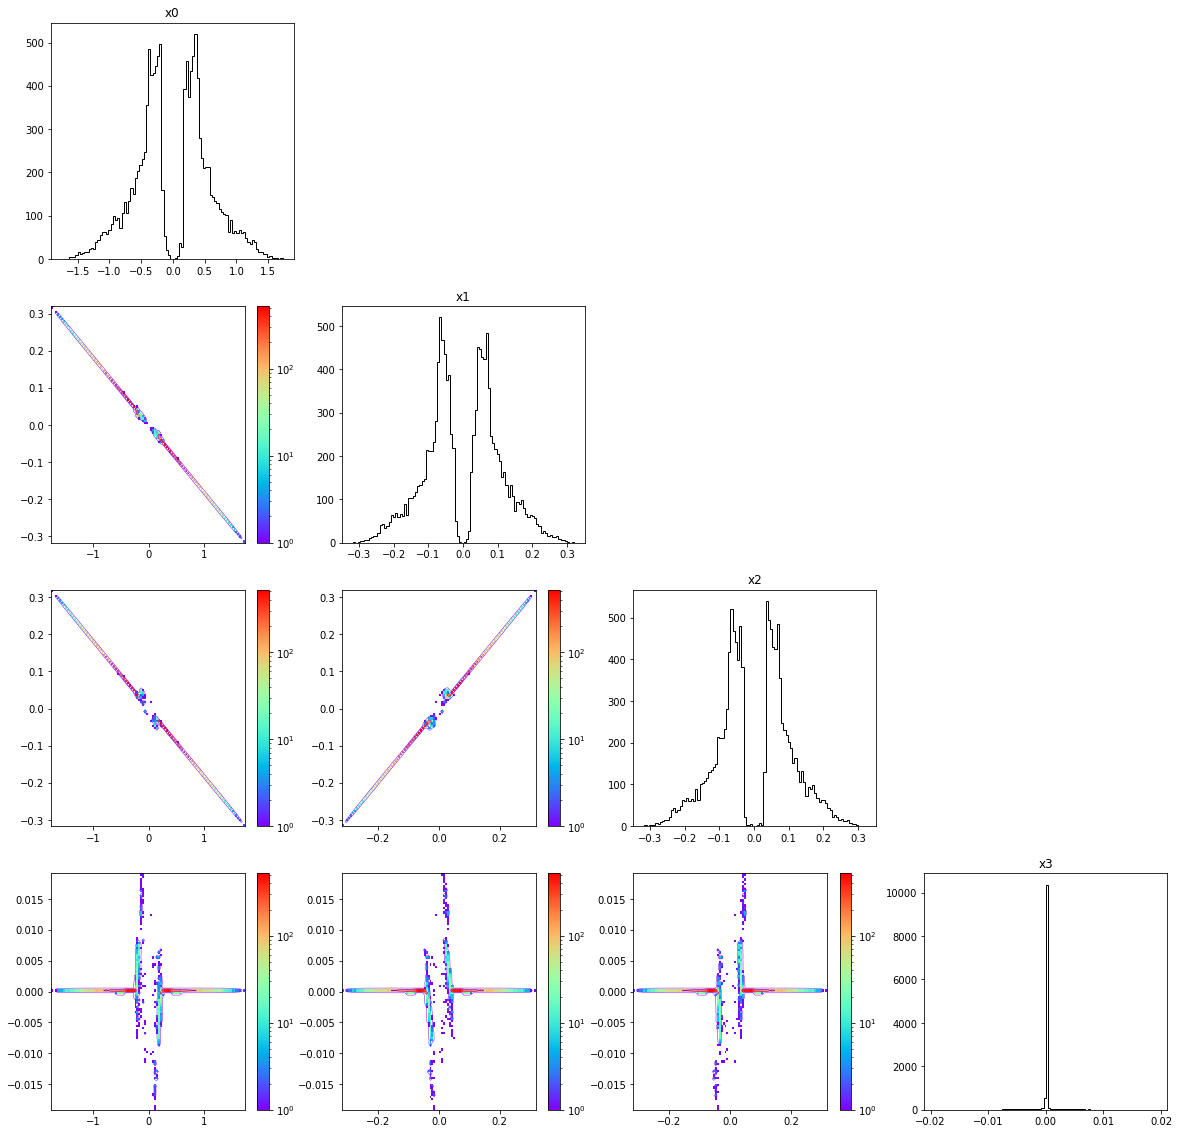

In [23]:
mask_points=is_on_axis(x2.numpy(),(0,1),-0.18,0.05)
points=np.transpose(np.array([np.extract(mask_points,x2[:,0].numpy()),np.extract(mask_points,x2[:,1].numpy()),np.extract(mask_points,x2[:,2].numpy()),np.extract(mask_points,x2[:,3].numpy())]))
triangular_plot(points)


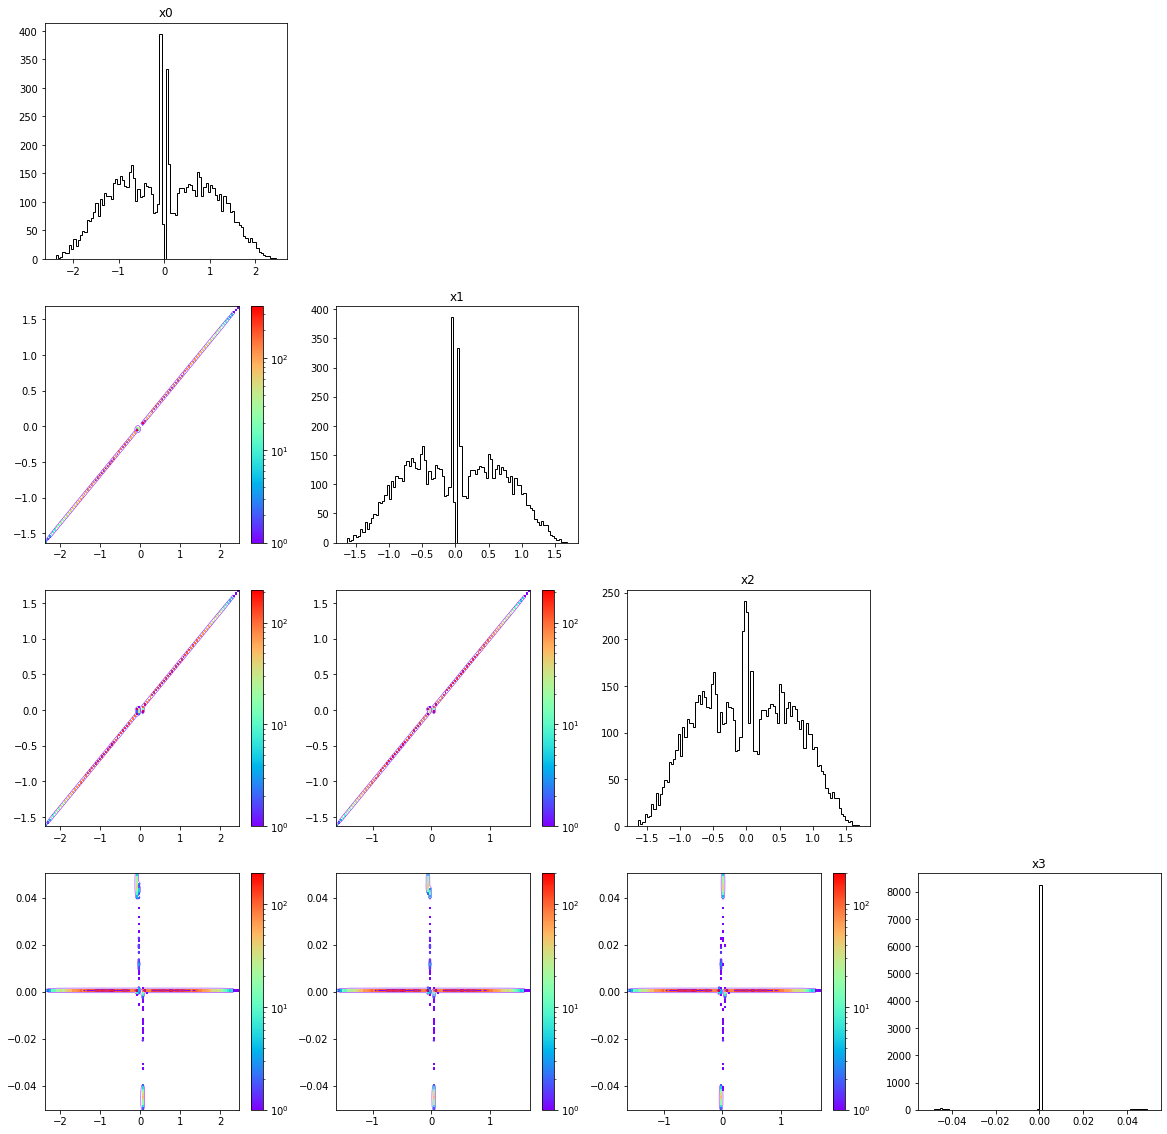

In [24]:
mask_points=is_on_axis(x2.numpy(),(0,1),0.68,0.1)
points=np.transpose(np.array([np.extract(mask_points,x2[:,0].numpy()),np.extract(mask_points,x2[:,1].numpy()),np.extract(mask_points,x2[:,2].numpy()),np.extract(mask_points,x2[:,3].numpy())]))
triangular_plot(points)


In [ ]:
#V3 potential plots and stats

In [50]:
# randomly initialize the points
n_points = 100000
x3 = tf.Variable(4*np.random.rand(n_points, 4)-2, dtype=tf.float32)

In [52]:
# Oprimizer for the gradient descent

init_alpha=10**(-2)
update_alpha = True

optimizer = tf.optimizers.Adam(learning_rate=alpha)
#optimizer = tf.optimizers.SGD(learning_rate=init_alpha,momentum=0.0)

# Learning loop 
loss_prev_step=10**8

alpha = init_alpha
update_alpha = False
update_opt = True
for step in range(2400):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(V3, x3)) # minimize ||∇V||^2 for all points
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [x3])

    if update_alpha and step % 300 == 0 and step != 0:
        alpha = alpha/2
        optimizer = tf.optimizers.Adam(learning_rate=alpha)
    if update_opt and step % 200 ==0 :
        print("Reinitializing the optimizer")
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    if loss.numpy()<10 and update_opt:
        update_alpha = True
        update_opt = False
        print("Turning update_alpha to True and update_opt to False")
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [x3]))
    
    if step % 10 == 0:
        print(f"""Step {step}: ||∇V||^2 = {loss.numpy()} with learning rate {optimizer.get_config()["learning_rate"]}""")
        
    if np.log(loss.numpy())/np.log(10)<-6: 
        print("Converged enough") 
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

Reinitializing the optimizer
Step 0: ||∇V||^2 = 1.4940524088278385e+18 with learning rate 0.009999999776482582
Step 10: ||∇V||^2 = 5.1796797065632154e+17 with learning rate 0.009999999776482582
Step 20: ||∇V||^2 = 2.1592082215233126e+17 with learning rate 0.009999999776482582
Step 30: ||∇V||^2 = 1.1478565527538893e+17 with learning rate 0.009999999776482582
Step 40: ||∇V||^2 = 7.4033004116181e+16 with learning rate 0.009999999776482582
Step 50: ||∇V||^2 = 5.415991555968205e+16 with learning rate 0.009999999776482582
Step 60: ||∇V||^2 = 4.273445214879744e+16 with learning rate 0.009999999776482582
Step 70: ||∇V||^2 = 3.5265261355401216e+16 with learning rate 0.009999999776482582
Step 80: ||∇V||^2 = 2.99162725777408e+16 with learning rate 0.009999999776482582
Step 90: ||∇V||^2 = 2.584703587791667e+16 with learning rate 0.009999999776482582
Step 100: ||∇V||^2 = 2.262754342522061e+16 with learning rate 0.009999999776482582
Step 110: ||∇V||^2 = 2.001279954767053e+16 with learning rate 0.009

Step 1050: ||∇V||^2 = 1281.50830078125 with learning rate 0.009999999776482582
Step 1060: ||∇V||^2 = 411.59356689453125 with learning rate 0.009999999776482582
Step 1070: ||∇V||^2 = 299.7628173828125 with learning rate 0.009999999776482582
Step 1080: ||∇V||^2 = 237.839599609375 with learning rate 0.009999999776482582
Step 1090: ||∇V||^2 = 171.88327026367188 with learning rate 0.009999999776482582
Step 1100: ||∇V||^2 = 151.37669372558594 with learning rate 0.009999999776482582
Step 1110: ||∇V||^2 = 133.25991821289062 with learning rate 0.009999999776482582
Step 1120: ||∇V||^2 = 121.04010009765625 with learning rate 0.009999999776482582
Step 1130: ||∇V||^2 = 111.4173812866211 with learning rate 0.009999999776482582
Step 1140: ||∇V||^2 = 103.03849792480469 with learning rate 0.009999999776482582
Step 1150: ||∇V||^2 = 95.66978454589844 with learning rate 0.009999999776482582
Step 1160: ||∇V||^2 = 89.16012573242188 with learning rate 0.009999999776482582
Step 1170: ||∇V||^2 = 83.33290863037

Step 2050: ||∇V||^2 = 1.1386098776711151e-05 with learning rate 0.0024999999441206455
Step 2060: ||∇V||^2 = 8.582890586694703e-06 with learning rate 0.0024999999441206455
Step 2070: ||∇V||^2 = 7.032307166809915e-06 with learning rate 0.0024999999441206455
Step 2080: ||∇V||^2 = 6.881561148475157e-06 with learning rate 0.0024999999441206455
Step 2090: ||∇V||^2 = 6.483806828327943e-06 with learning rate 0.0024999999441206455
Step 2100: ||∇V||^2 = 0.00016598294314462692 with learning rate 0.0012499999720603228
Step 2110: ||∇V||^2 = 1400.2418212890625 with learning rate 0.0012499999720603228
Step 2120: ||∇V||^2 = 254.0369873046875 with learning rate 0.0012499999720603228
Step 2130: ||∇V||^2 = 23.730018615722656 with learning rate 0.0012499999720603228
Step 2140: ||∇V||^2 = 31.92056655883789 with learning rate 0.0012499999720603228
Step 2150: ||∇V||^2 = 16.392559051513672 with learning rate 0.0012499999720603228
Step 2160: ||∇V||^2 = 5.782623291015625 with learning rate 0.0012499999720603228

In [53]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(tf.reduce_sum(get_grad(V3,x3)**2,axis=1).numpy()>10**(-i))}")


Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 0
Number of points with ||∇V||^2 > 1e-05 : 0
Number of points with ||∇V||^2 > 1e-06 : 0
Number of points with ||∇V||^2 > 1e-07 : 2
Number of points with ||∇V||^2 > 1e-08 : 38
Number of points with ||∇V||^2 > 1e-09 : 184
Number of points with ||∇V||^2 > 1e-10 : 1517
Number of points with ||∇V||^2 > 1e-11 : 15865
Number of points with ||∇V||^2 > 1e-12 : 59438
Number of points with ||∇V||^2 > 1e-13 : 65645
Number of points with ||∇V||^2 > 1e-14 : 69090


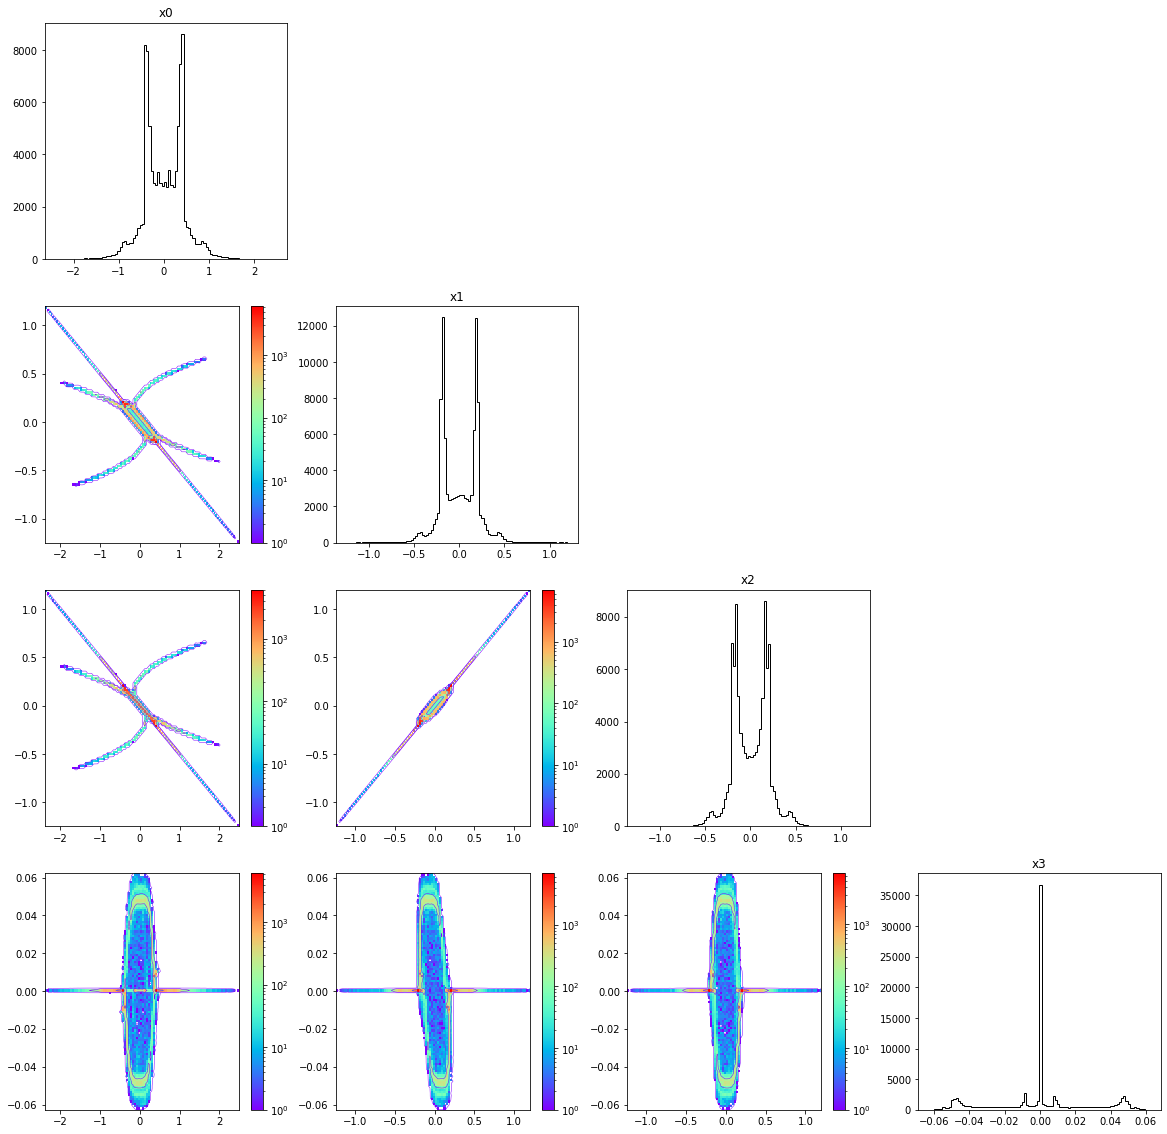

In [54]:
triangular_plot(x3.numpy())

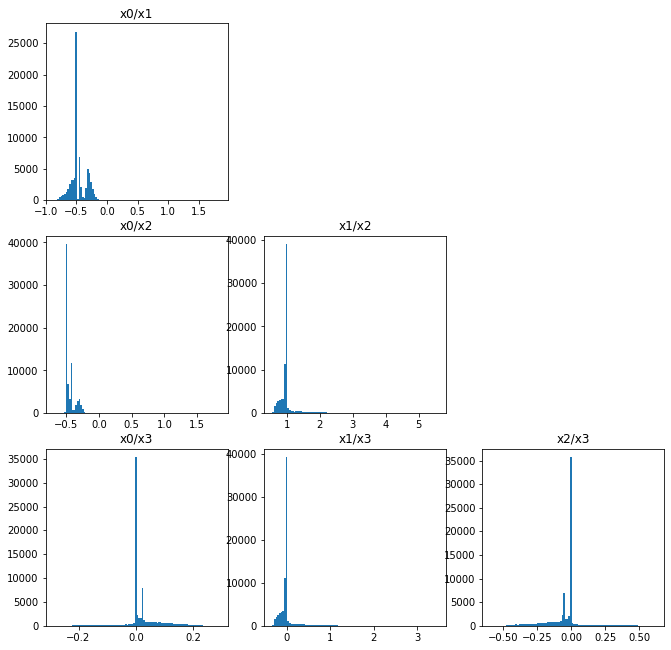

In [55]:
triangular_plot_slopes(x3)

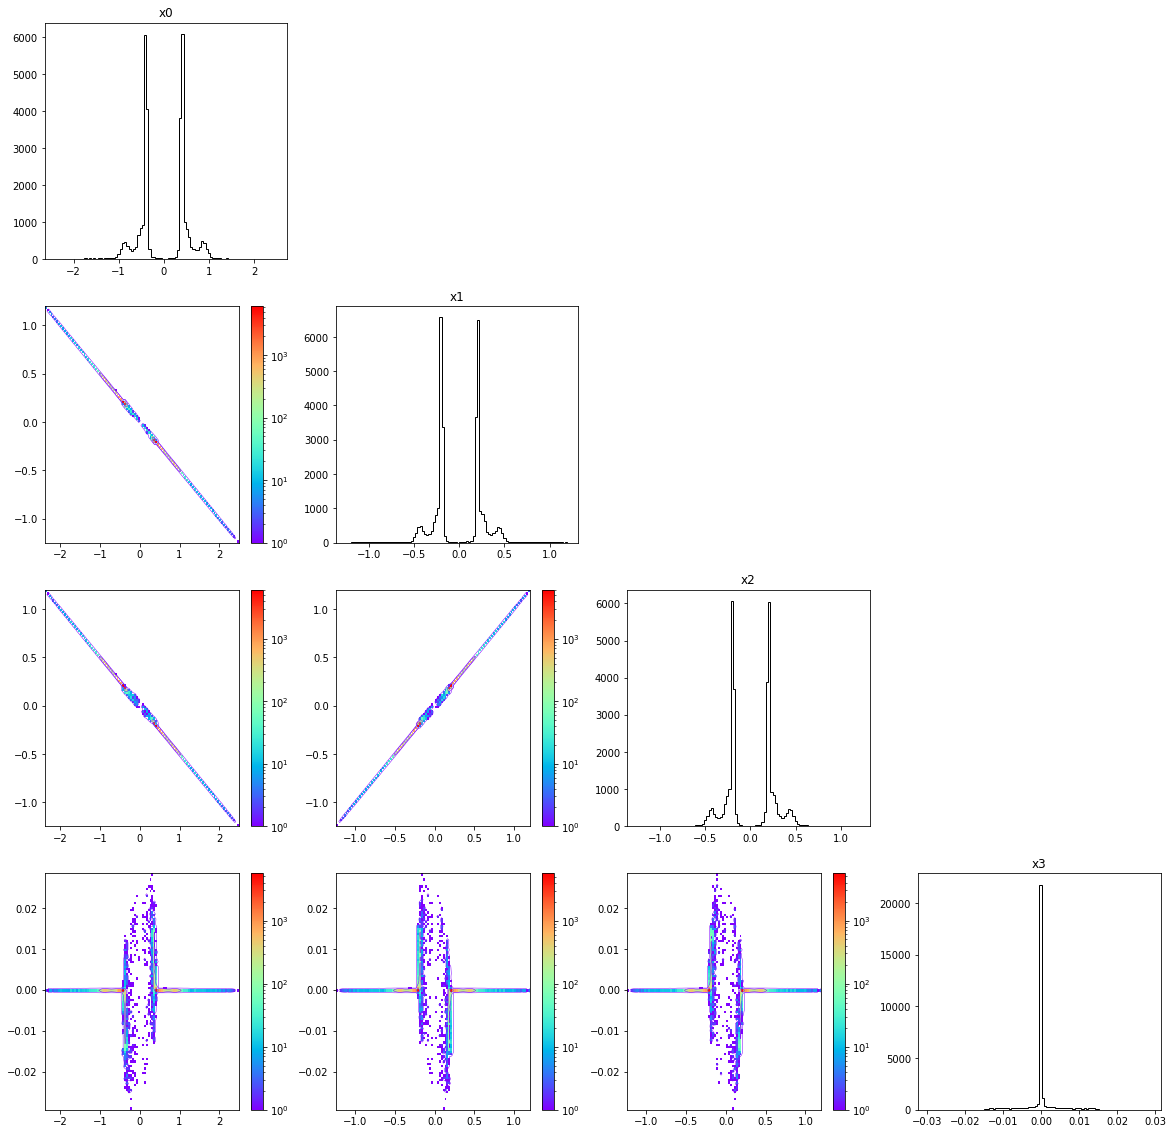

In [56]:
mask_points_m5=is_on_axis(x3.numpy(),(0,1),-0.5,0.05)
points_m5=np.transpose(np.array([np.extract(mask_points_m5,x3[:,0].numpy()),np.extract(mask_points_m5,x3[:,1].numpy()),np.extract(mask_points_m5,x3[:,2].numpy()),np.extract(mask_points_m5,x3[:,3].numpy())]))
triangular_plot(points_m5)

In [7]:
mask_points_m5=is_on_x_squared(x3.numpy(),(0,1),(4*np.sqrt(3),-2,0),0.05)
points_m5=np.transpose(np.array([np.extract(mask_points_m5,x3[:,0].numpy()),np.extract(mask_points_m5,x3[:,1].numpy()),np.extract(mask_points_m5,x3[:,2].numpy()),np.extract(mask_points_m5,x3[:,3].numpy())]))
triangular_plot(points_m5)

NameError: name 'x3' is not defined

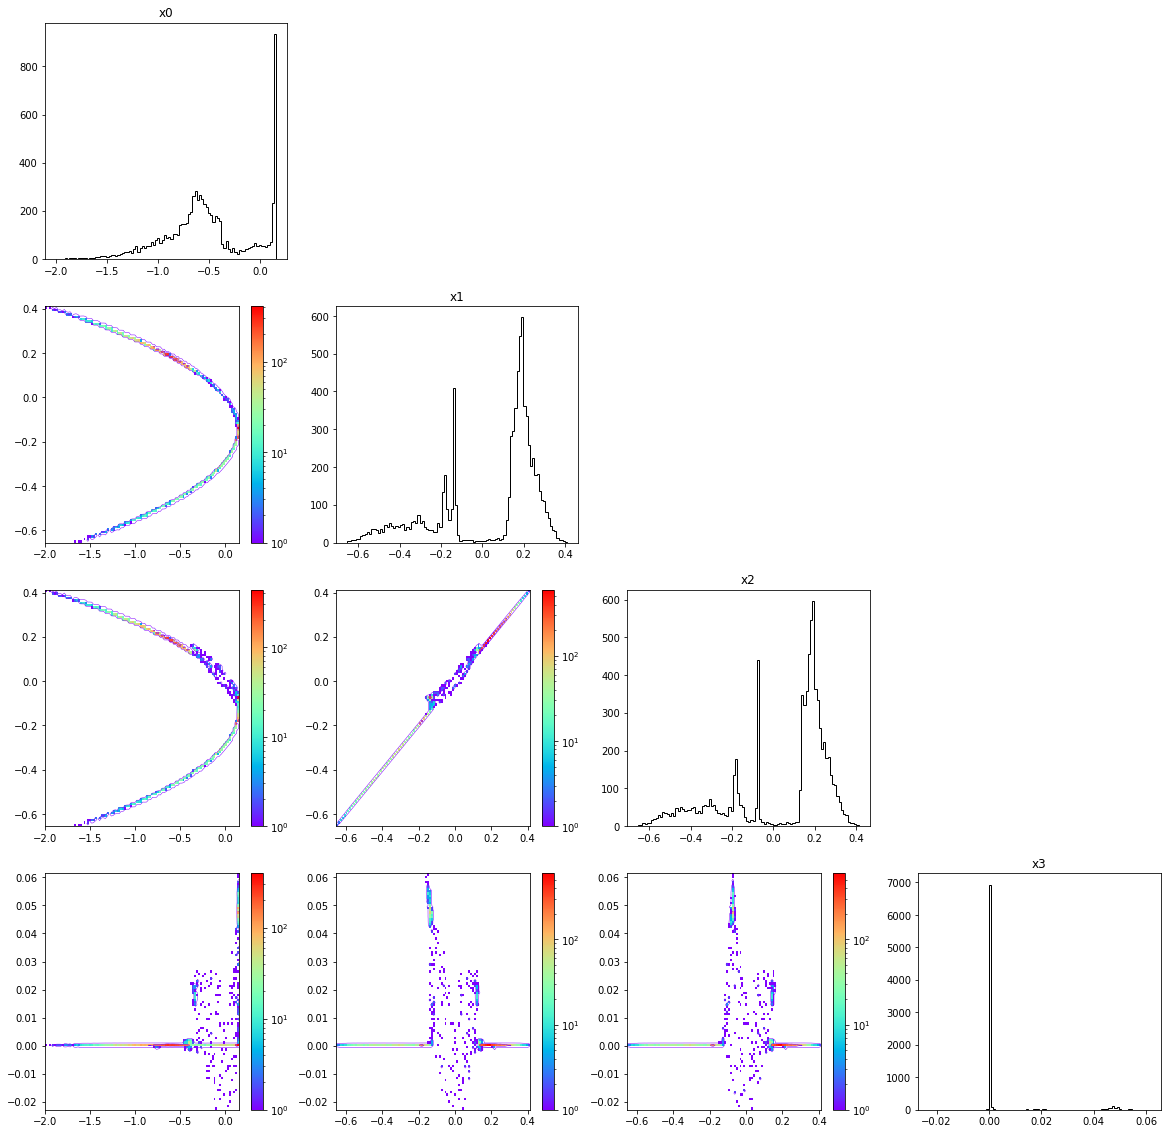

In [60]:
mask_points_m5=is_on_x_squared(x3.numpy(),(0,1),(-4*np.sqrt(3),-2,0),0.01)
points_m5=np.transpose(np.array([np.extract(mask_points_m5,x3[:,0].numpy()),np.extract(mask_points_m5,x3[:,1].numpy()),np.extract(mask_points_m5,x3[:,2].numpy()),np.extract(mask_points_m5,x3[:,3].numpy())]))
triangular_plot(points_m5)

In [255]:
# Higgs like potential 

In [339]:
def VHiggs(x):
    x1,x2,x3,x4=tf.split(x, 4, axis=1)
    return x1**2*(x1**2+x2**2-1)**2*(x3**2+x4**2-1)**2
def VHiggs_scrambled(x):
    x1,x2,x3,x4=tf.split(x, 4, axis=1)
    return (x1 + x2 + x3 + x4)**2 * (-1 + x4**2 + (-x2 + x3 + x4)**2)**2 * (-1 + (x2 + x3 + x4)**2 + (x1 + x2 + x3 + x4)**2)**2


In [360]:
# randomly initialize the points
n_points = 10000
xHiggs = tf.Variable(4*np.random.rand(n_points, 4)-2, dtype=tf.float32)
historyHiggs = []

xHiggs_scrambled = tf.Variable(4*np.random.rand(n_points, 4)-2, dtype=tf.float32)
historyHiggs_scrambled = []

In [371]:
# Oprimizer for the gradient descent

init_alpha=10**(-5)

optimizer = tf.optimizers.Adam(learning_rate=alpha)
#optimizer = tf.optimizers.SGD(learning_rate=init_alpha,momentum=0.0)

# Learning loop 
loss_prev_step=10**8

alpha = init_alpha
#update_alpha = False
update_opt = False
for step in range(10000):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(VHiggs_scrambled, xHiggs_scrambled)) # minimize ||∇V||^2 for all points
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [xHiggs_scrambled])

    #if update_alpha and step % 300 == 0 and step != 0:
    #    alpha = alpha/2
    #    optimizer = tf.optimizers.Adam(learning_rate=alpha)
    if update_opt and step % 200 ==0 :
        print("Reinitializing the optimizer")
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    
    if step == 801:
        update_opt = False 
        optimizer.learning_rate.assign(0.0001)
    #if loss.numpy()<10 and update_opt:
    #    #update_alpha = True
    #    update_opt = False
    #    print("Turning update_alpha to True and update_opt to False")
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [xHiggs_scrambled]))
    
    historyHiggs_scrambled.append(loss)
    
    if step % 10 == 0:
        print(f"""Step {step}: ||∇V||^2 = {loss.numpy()} with learning rate {optimizer.get_config()["learning_rate"]}""")
        
    if np.log(loss.numpy())/np.log(10)<-10: 
        print("Converged enough") 
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

Step 0: ||∇V||^2 = 46.392120361328125 with learning rate 9.999999747378752e-05
Step 10: ||∇V||^2 = 65208.859375 with learning rate 9.999999747378752e-05
Step 20: ||∇V||^2 = 12310.8681640625 with learning rate 9.999999747378752e-05
Step 30: ||∇V||^2 = 112.77220153808594 with learning rate 9.999999747378752e-05
Step 40: ||∇V||^2 = 1139.546142578125 with learning rate 9.999999747378752e-05
Step 50: ||∇V||^2 = 730.8773193359375 with learning rate 9.999999747378752e-05
Step 60: ||∇V||^2 = 261.52276611328125 with learning rate 9.999999747378752e-05
Step 70: ||∇V||^2 = 54.221717834472656 with learning rate 9.999999747378752e-05
Step 80: ||∇V||^2 = 2.9037981033325195 with learning rate 9.999999747378752e-05
Step 90: ||∇V||^2 = 9.369705200195312 with learning rate 9.999999747378752e-05
Step 100: ||∇V||^2 = 7.041385173797607 with learning rate 9.999999747378752e-05
Step 110: ||∇V||^2 = 0.46218687295913696 with learning rate 9.999999747378752e-05
Step 120: ||∇V||^2 = 1.048126459121704 with learni

Step 1010: ||∇V||^2 = 0.05463208258152008 with learning rate 9.999999747378752e-05
Step 1020: ||∇V||^2 = 0.06378800421953201 with learning rate 9.999999747378752e-05
Step 1030: ||∇V||^2 = 0.0617084875702858 with learning rate 9.999999747378752e-05
Step 1040: ||∇V||^2 = 0.05944143235683441 with learning rate 9.999999747378752e-05
Step 1050: ||∇V||^2 = 0.0564177930355072 with learning rate 9.999999747378752e-05
Step 1060: ||∇V||^2 = 0.06233011931180954 with learning rate 9.999999747378752e-05
Step 1070: ||∇V||^2 = 0.062284134328365326 with learning rate 9.999999747378752e-05
Step 1080: ||∇V||^2 = 0.05652441084384918 with learning rate 9.999999747378752e-05
Step 1090: ||∇V||^2 = 0.05969872698187828 with learning rate 9.999999747378752e-05
Step 1100: ||∇V||^2 = 0.05481164902448654 with learning rate 9.999999747378752e-05
Step 1110: ||∇V||^2 = 0.06388518214225769 with learning rate 9.999999747378752e-05
Step 1120: ||∇V||^2 = 0.058094270527362823 with learning rate 9.999999747378752e-05
Step

Step 2000: ||∇V||^2 = 117.68962097167969 with learning rate 9.999999747378752e-05
Step 2010: ||∇V||^2 = 169.35601806640625 with learning rate 9.999999747378752e-05
Step 2020: ||∇V||^2 = 77.92475891113281 with learning rate 9.999999747378752e-05
Step 2030: ||∇V||^2 = 174.3116455078125 with learning rate 9.999999747378752e-05
Step 2040: ||∇V||^2 = 22.048805236816406 with learning rate 9.999999747378752e-05
Step 2050: ||∇V||^2 = 57.63105010986328 with learning rate 9.999999747378752e-05
Step 2060: ||∇V||^2 = 73.08260345458984 with learning rate 9.999999747378752e-05
Step 2070: ||∇V||^2 = 786.7325439453125 with learning rate 9.999999747378752e-05
Step 2080: ||∇V||^2 = 418.8822326660156 with learning rate 9.999999747378752e-05
Step 2090: ||∇V||^2 = 222.1950225830078 with learning rate 9.999999747378752e-05
Step 2100: ||∇V||^2 = 117.2991714477539 with learning rate 9.999999747378752e-05
Step 2110: ||∇V||^2 = 274.13165283203125 with learning rate 9.999999747378752e-05
Step 2120: ||∇V||^2 = 33

Step 3010: ||∇V||^2 = 70.75473022460938 with learning rate 9.999999747378752e-05
Step 3020: ||∇V||^2 = 33.46882629394531 with learning rate 9.999999747378752e-05
Step 3030: ||∇V||^2 = 31.4703311920166 with learning rate 9.999999747378752e-05
Step 3040: ||∇V||^2 = 325.6690673828125 with learning rate 9.999999747378752e-05
Step 3050: ||∇V||^2 = 235.24176025390625 with learning rate 9.999999747378752e-05
Step 3060: ||∇V||^2 = 461.5032958984375 with learning rate 9.999999747378752e-05
Step 3070: ||∇V||^2 = 115.89907836914062 with learning rate 9.999999747378752e-05
Step 3080: ||∇V||^2 = 63.05792999267578 with learning rate 9.999999747378752e-05
Step 3090: ||∇V||^2 = 18.84758949279785 with learning rate 9.999999747378752e-05
Step 3100: ||∇V||^2 = 49.293270111083984 with learning rate 9.999999747378752e-05
Step 3110: ||∇V||^2 = 20.594837188720703 with learning rate 9.999999747378752e-05
Step 3120: ||∇V||^2 = 31.31340217590332 with learning rate 9.999999747378752e-05
Step 3130: ||∇V||^2 = 61.

Step 4020: ||∇V||^2 = 37.75450134277344 with learning rate 9.999999747378752e-05
Step 4030: ||∇V||^2 = 71.84455108642578 with learning rate 9.999999747378752e-05
Step 4040: ||∇V||^2 = 32.36880874633789 with learning rate 9.999999747378752e-05
Step 4050: ||∇V||^2 = 48.82440948486328 with learning rate 9.999999747378752e-05
Step 4060: ||∇V||^2 = 110.3466796875 with learning rate 9.999999747378752e-05
Step 4070: ||∇V||^2 = 176.05560302734375 with learning rate 9.999999747378752e-05
Step 4080: ||∇V||^2 = 117.7912826538086 with learning rate 9.999999747378752e-05
Step 4090: ||∇V||^2 = 85.6807632446289 with learning rate 9.999999747378752e-05
Step 4100: ||∇V||^2 = 90.01937103271484 with learning rate 9.999999747378752e-05
Step 4110: ||∇V||^2 = 72.22118377685547 with learning rate 9.999999747378752e-05
Step 4120: ||∇V||^2 = 104.43803405761719 with learning rate 9.999999747378752e-05
Step 4130: ||∇V||^2 = 105.55806732177734 with learning rate 9.999999747378752e-05
Step 4140: ||∇V||^2 = 522.055

Step 5030: ||∇V||^2 = 403.6216735839844 with learning rate 9.999999747378752e-05
Step 5040: ||∇V||^2 = 97.90299224853516 with learning rate 9.999999747378752e-05
Step 5050: ||∇V||^2 = 37.776344299316406 with learning rate 9.999999747378752e-05
Step 5060: ||∇V||^2 = 49.967262268066406 with learning rate 9.999999747378752e-05
Step 5070: ||∇V||^2 = 24.848369598388672 with learning rate 9.999999747378752e-05
Step 5080: ||∇V||^2 = 42.077003479003906 with learning rate 9.999999747378752e-05
Step 5090: ||∇V||^2 = 25.601882934570312 with learning rate 9.999999747378752e-05
Step 5100: ||∇V||^2 = 35.755985260009766 with learning rate 9.999999747378752e-05
Step 5110: ||∇V||^2 = 28.09613037109375 with learning rate 9.999999747378752e-05
Step 5120: ||∇V||^2 = 45.73114776611328 with learning rate 9.999999747378752e-05
Step 5130: ||∇V||^2 = 42.222068786621094 with learning rate 9.999999747378752e-05
Step 5140: ||∇V||^2 = 28.71675682067871 with learning rate 9.999999747378752e-05
Step 5150: ||∇V||^2 =

Step 6040: ||∇V||^2 = 55.727806091308594 with learning rate 9.999999747378752e-05
Step 6050: ||∇V||^2 = 112.01675415039062 with learning rate 9.999999747378752e-05
Step 6060: ||∇V||^2 = 54.48302459716797 with learning rate 9.999999747378752e-05
Step 6070: ||∇V||^2 = 33.82118606567383 with learning rate 9.999999747378752e-05
Step 6080: ||∇V||^2 = 46.56378936767578 with learning rate 9.999999747378752e-05
Step 6090: ||∇V||^2 = 47.52894592285156 with learning rate 9.999999747378752e-05
Step 6100: ||∇V||^2 = 80.62532043457031 with learning rate 9.999999747378752e-05
Step 6110: ||∇V||^2 = 54.0975456237793 with learning rate 9.999999747378752e-05
Step 6120: ||∇V||^2 = 23.031391143798828 with learning rate 9.999999747378752e-05
Step 6130: ||∇V||^2 = 15.053771018981934 with learning rate 9.999999747378752e-05
Step 6140: ||∇V||^2 = 10.279397010803223 with learning rate 9.999999747378752e-05
Step 6150: ||∇V||^2 = 290.3571472167969 with learning rate 9.999999747378752e-05
Step 6160: ||∇V||^2 = 19

Step 7050: ||∇V||^2 = 351.468017578125 with learning rate 9.999999747378752e-05
Step 7060: ||∇V||^2 = 71.28857421875 with learning rate 9.999999747378752e-05
Step 7070: ||∇V||^2 = 80.45136260986328 with learning rate 9.999999747378752e-05
Step 7080: ||∇V||^2 = 31.72044563293457 with learning rate 9.999999747378752e-05
Step 7090: ||∇V||^2 = 19.825157165527344 with learning rate 9.999999747378752e-05
Step 7100: ||∇V||^2 = 114.02849578857422 with learning rate 9.999999747378752e-05
Step 7110: ||∇V||^2 = 60.329315185546875 with learning rate 9.999999747378752e-05
Step 7120: ||∇V||^2 = 33.96674346923828 with learning rate 9.999999747378752e-05
Step 7130: ||∇V||^2 = 16.08070945739746 with learning rate 9.999999747378752e-05
Step 7140: ||∇V||^2 = 62.689605712890625 with learning rate 9.999999747378752e-05
Step 7150: ||∇V||^2 = 21.651262283325195 with learning rate 9.999999747378752e-05
Step 7160: ||∇V||^2 = 18.54137420654297 with learning rate 9.999999747378752e-05
Step 7170: ||∇V||^2 = 17.35

Step 8060: ||∇V||^2 = 3466.69921875 with learning rate 9.999999747378752e-05
Step 8070: ||∇V||^2 = 885.9027099609375 with learning rate 9.999999747378752e-05
Step 8080: ||∇V||^2 = 352.3089904785156 with learning rate 9.999999747378752e-05
Step 8090: ||∇V||^2 = 130.55838012695312 with learning rate 9.999999747378752e-05
Step 8100: ||∇V||^2 = 142.8581085205078 with learning rate 9.999999747378752e-05
Step 8110: ||∇V||^2 = 69.77692413330078 with learning rate 9.999999747378752e-05
Step 8120: ||∇V||^2 = 21.30524253845215 with learning rate 9.999999747378752e-05
Step 8130: ||∇V||^2 = 15.197551727294922 with learning rate 9.999999747378752e-05
Step 8140: ||∇V||^2 = 20.40145492553711 with learning rate 9.999999747378752e-05
Step 8150: ||∇V||^2 = 12.614751815795898 with learning rate 9.999999747378752e-05
Step 8160: ||∇V||^2 = 14.865394592285156 with learning rate 9.999999747378752e-05
Step 8170: ||∇V||^2 = 78.25908660888672 with learning rate 9.999999747378752e-05
Step 8180: ||∇V||^2 = 30.769

Step 9070: ||∇V||^2 = 32.69925308227539 with learning rate 9.999999747378752e-05
Step 9080: ||∇V||^2 = 13.89468002319336 with learning rate 9.999999747378752e-05
Step 9090: ||∇V||^2 = 114.30563354492188 with learning rate 9.999999747378752e-05
Step 9100: ||∇V||^2 = 32.53410339355469 with learning rate 9.999999747378752e-05
Step 9110: ||∇V||^2 = 39.31363296508789 with learning rate 9.999999747378752e-05
Step 9120: ||∇V||^2 = 11.52426815032959 with learning rate 9.999999747378752e-05
Step 9130: ||∇V||^2 = 33.50723648071289 with learning rate 9.999999747378752e-05
Step 9140: ||∇V||^2 = 33.86334991455078 with learning rate 9.999999747378752e-05
Step 9150: ||∇V||^2 = 22.532114028930664 with learning rate 9.999999747378752e-05
Step 9160: ||∇V||^2 = 11.082940101623535 with learning rate 9.999999747378752e-05
Step 9170: ||∇V||^2 = 93.5787124633789 with learning rate 9.999999747378752e-05
Step 9180: ||∇V||^2 = 166.90524291992188 with learning rate 9.999999747378752e-05
Step 9190: ||∇V||^2 = 165

In [372]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(tf.reduce_sum(get_grad(VHiggs,xHiggs)**2,axis=1).numpy()>10**(-i))} and Number of points (scrambled) with ||∇V||^2 > {10**(-i)} : {sum(tf.reduce_sum(get_grad(VHiggs_scrambled,xHiggs_scrambled)**2,axis=1).numpy()>10**(-i))}")
    

Number of points with ||∇V||^2 > 1 : 0 and Number of points (scrambled) with ||∇V||^2 > 1 : 7
Number of points with ||∇V||^2 > 0.1 : 0 and Number of points (scrambled) with ||∇V||^2 > 0.1 : 18
Number of points with ||∇V||^2 > 0.01 : 0 and Number of points (scrambled) with ||∇V||^2 > 0.01 : 39
Number of points with ||∇V||^2 > 0.001 : 0 and Number of points (scrambled) with ||∇V||^2 > 0.001 : 67
Number of points with ||∇V||^2 > 0.0001 : 0 and Number of points (scrambled) with ||∇V||^2 > 0.0001 : 113
Number of points with ||∇V||^2 > 1e-05 : 0 and Number of points (scrambled) with ||∇V||^2 > 1e-05 : 187
Number of points with ||∇V||^2 > 1e-06 : 2 and Number of points (scrambled) with ||∇V||^2 > 1e-06 : 260
Number of points with ||∇V||^2 > 1e-07 : 3 and Number of points (scrambled) with ||∇V||^2 > 1e-07 : 330
Number of points with ||∇V||^2 > 1e-08 : 5 and Number of points (scrambled) with ||∇V||^2 > 1e-08 : 408
Number of points with ||∇V||^2 > 1e-09 : 18 and Number of points (scrambled) with

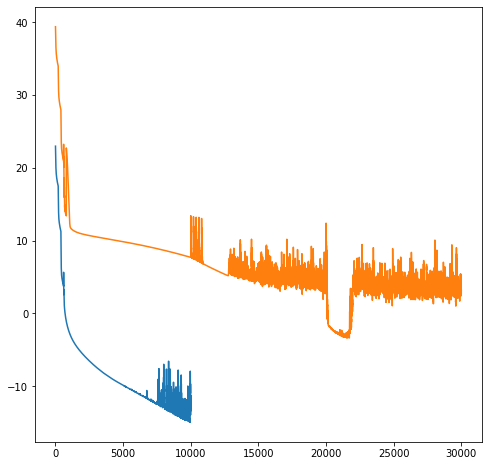

In [373]:
#all_steps = np.linspace(1,len(history),len(history))
plt.figure(figsize=(8,8))
plt.plot(np.log(historyHiggs))
plt.plot(np.log(historyHiggs_scrambled))
plt.show()

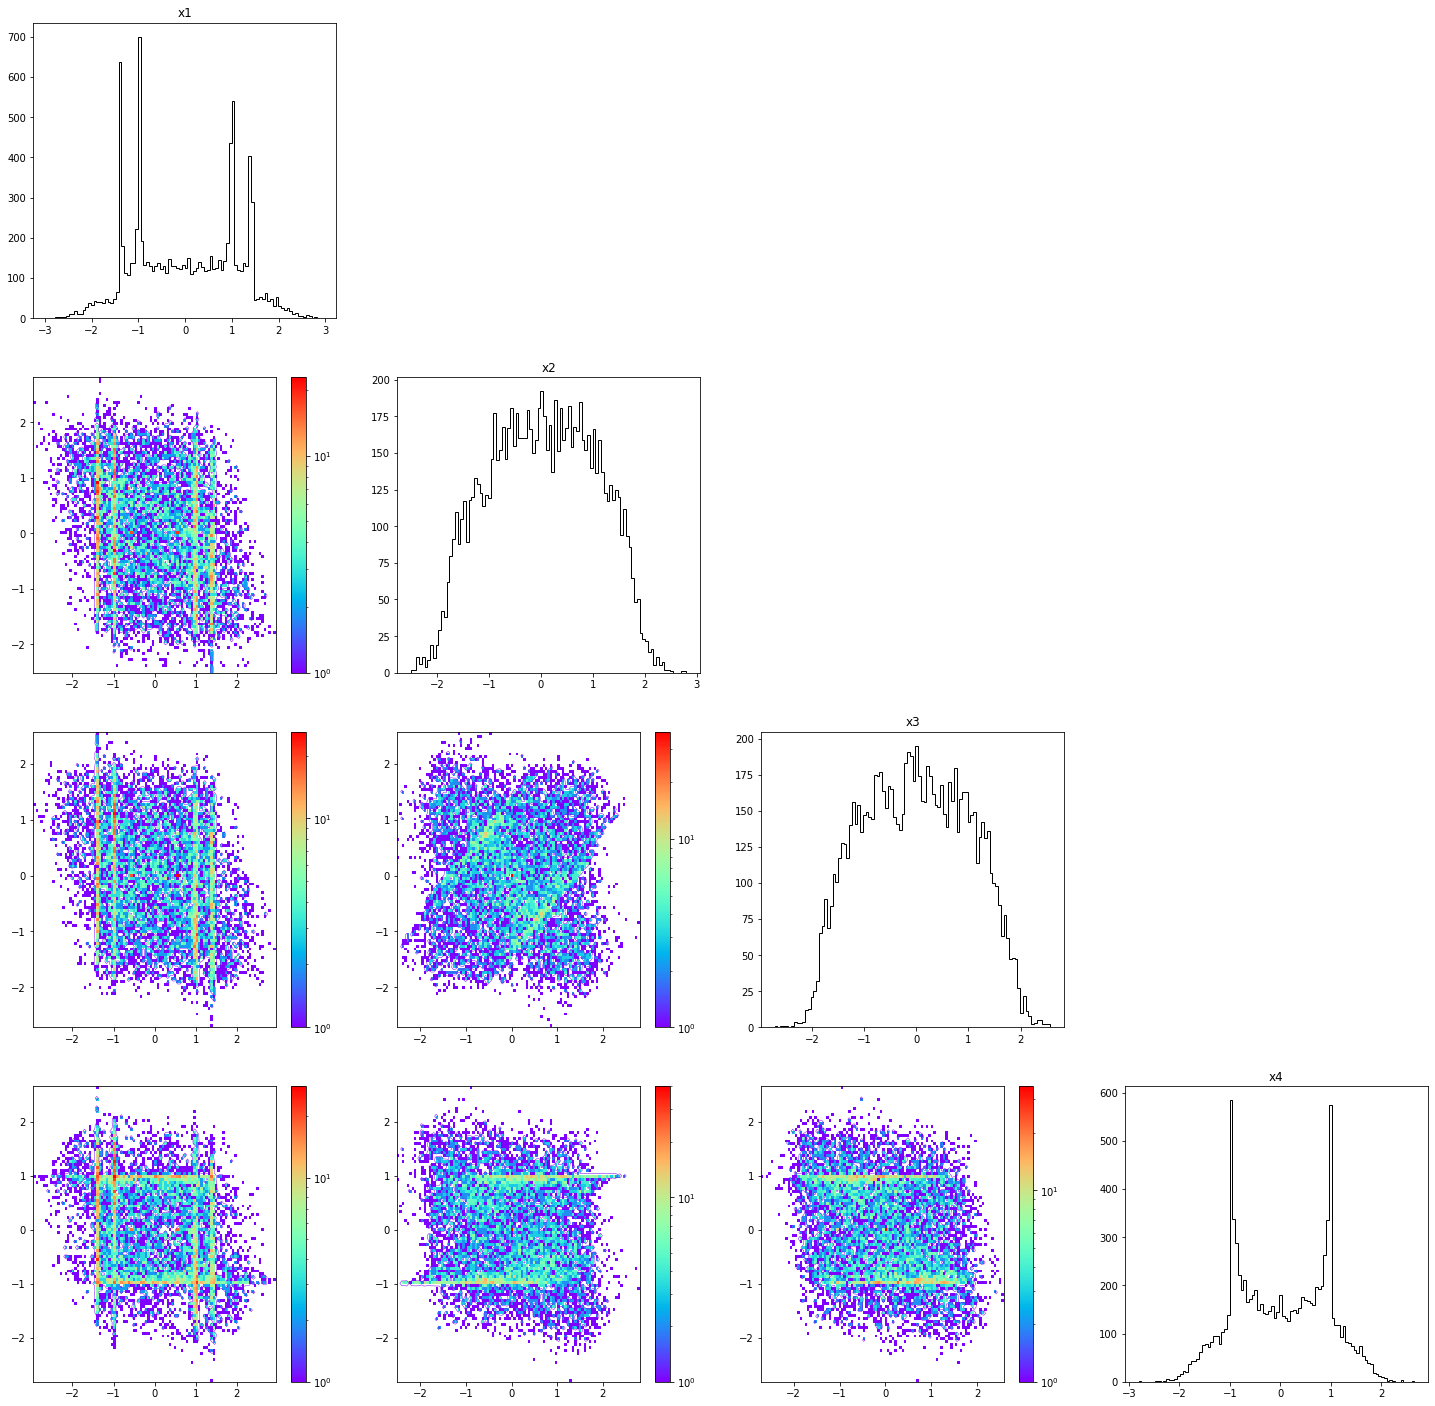

In [374]:
triangular_plot(xHiggs_scrambled.numpy())

In [ ]:
# 13 d 

In [183]:
def V13(x):
    #x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13=tf.split(x,13, axis=1)
    x3,x7,x9=tf.split(x,3, axis=1)
    x1 = 0
    x2 = 0
    x4 = 0
    x5 = 0
    x6 = 0
    x8 = 0
    x10 = 0
    x11 = 0
    x12 = 0
    x13 = 0
    #return 0.001953125 * (x13 ** 2) * (x7 ** -6) * (x8 ** -2) * (x9 ** (-4 * (3 ** -0.5))) * (256 * (x7 ** 4) * ((x8 + 4 * (x4 ** 2) * x8) ** 2) + 2048 * (x1 ** 2) * (x4 ** 2) * (x7 ** 6) * x8 * (x9 ** (3 ** -0.5)) -2048 * (np.sqrt(2)) * x1 * x10 * x2 * (x4 ** 2) * (x7 ** 6) * (x8 ** 2) * (x9 ** (3 ** -0.5)) + 1024 * (2 + x10 ** 2) * (x2 ** 2) * (x4 ** 2) * (x7 ** 6) * (x8 ** 3) * (x9 ** (3 ** -0.5)) + 256 * (x1 ** 4) * (x7 ** 8) * (x9 ** (2 * (3 ** -0.5))) -512 * (np.sqrt(2)) * (x1 ** 3) * x10 * x2 * (x7 ** 8) * x8 * (x9 ** (2 * (3 ** -0.5))) + 512 * ((x3 + 4 * x3 * (x4 ** 2) -4 * x2 * x4 * x5 + 4 * x1 * x4 * x6) ** 2) * (x7 ** 2) * (x8 ** 2) * (x9 ** (2 * (3 ** -0.5))) + 256 * (-2 + (x1 ** 2) * (2 + 3 * (x10 ** 2)) * (x2 ** 2) + 8 * (x4 ** 2)) * (x7 ** 8) * (x8 ** 2) * (x9 ** (2 * (3 ** -0.5))) -256 * (np.sqrt(2)) * x1 * x10 * (2 + x10 ** 2) * (x2 ** 3) * (x7 ** 8) * (x8 ** 3) * (x9 ** (2 * (3 ** -0.5))) + 64 * ((2 + x10 ** 2) ** 2) * (x2 ** 4) * (x7 ** 8) * (x8 ** 4) * (x9 ** (2 * (3 ** -0.5))) -2048 * (np.sqrt(2)) * (x1 ** 2) * x12 * x4 * x5 * (x7 ** 6) * (np.sqrt(x8)) * (x9 ** (2.5 * (3 ** -0.5))) + 1024 * x1 * x4 * (2 * (np.sqrt(2)) * x11 * (-(x3 * x4) + x1 * x6) + x10 * x12 * (x3 * x4 + 4 * x2 * x5 + x1 * x6)) * (x7 ** 6) * (x8 ** 1.5) * (x9 ** (2.5 * (3 ** -0.5))) -512 * x2 * x4 * (4 * (np.sqrt(2)) * x12 * (x3 * x4 + x2 * x5) + (np.sqrt(2)) * (x10 ** 2) * x12 * (x3 * x4 + 2 * x2 * x5 + 2 * x1 * x6) + x10 * x11 * (-4 * x3 * x4 + 8 * x1 * x6)) * (x7 ** 6) * (x8 ** 2.5) * (x9 ** (2.5 * (3 ** -0.5))) + 512 * (2 + x10 ** 2) * (2 * (np.sqrt(2)) * x11 + x10 * x12) * (x2 ** 2) * x4 * x6 * (x7 ** 6) * (x8 ** 3.5) * (x9 ** (2.5 * (3 ** -0.5))) -256 * (x1 ** 3) * (2 * (np.sqrt(2)) * x11 -(x10 * x12)) * x3 * (x7 ** 8) * (np.sqrt(x8)) * (x9 ** (3.5 * (3 ** -0.5))) -512 * (np.sqrt(2)) * x12 * (4 * (x2 ** 2) * x4 * x5 * (1 + 4 * (x5 ** 2)) -(x2 * (x3 + 4 * x3 * (x5 ** 2) + 4 * x3 * (x4 ** 2) * (1 + 8 * (x5 ** 2)) + 4 * x1 * x4 * (1 + 8 * (x5 ** 2)) * x6)) + 4 * x5 * ((x3 ** 2) * (x4 + 4 * (x4 ** 3)) + x1 * x3 * (1 + 8 * (x4 ** 2)) * x6 + 4 * (x1 ** 2) * x4 * (x6 ** 2))) * (x7 ** 2) * (x8 ** 1.5) * (x9 ** (3.5 * (3 ** -0.5))) -128 * ((x1 ** 2) * (-12 * x10 * x11 + 4 * (np.sqrt(2)) * x12 + 3 * (np.sqrt(2)) * (x10 ** 2) * x12) * x2 * x3 + 16 * (np.sqrt(2)) * x12 * x4 * x5) * (x7 ** 8) * (x8 ** 1.5) * (x9 ** (3.5 * (3 ** -0.5))) + 256 * (2 * (np.sqrt(2)) * x11 + x10 * x12) * (4 * ((x3 ** 2) * (x4 + 4 * (x4 ** 3)) -(x2 * x3 * (1 + 8 * (x4 ** 2)) * x5) + 4 * (x2 ** 2) * x4 * (x5 ** 2)) * x6 + 4 * (x1 ** 2) * x4 * x6 * (1 + 4 * (x6 ** 2)) + x1 * (x3 + 4 * x3 * (x6 ** 2) + 4 * x3 * (x4 ** 2) * (1 + 8 * (x6 ** 2)) -4 * x2 * x4 * x5 * (1 + 8 * (x6 ** 2)))) * (x7 ** 2) * (x8 ** 2.5) * (x9 ** (3.5 * (3 ** -0.5))) -128 * (x1 * (2 * (np.sqrt(2)) * (2 + 3 * (x10 ** 2)) * x11 -(x10 * (10 + 3 * (x10 ** 2)) * x12)) * (x2 ** 2) * x3 -8 * (2 * (np.sqrt(2)) * x11 + x10 * x12) * x4 * x6) * (x7 ** 8) * (x8 ** 2.5) * (x9 ** (3.5 * (3 ** -0.5))) -64 * (2 + x10 ** 2) * (-4 * x10 * x11 + 4 * (np.sqrt(2)) * x12 + (np.sqrt(2)) * (x10 ** 2) * x12) * (x2 ** 3) * x3 * (x7 ** 8) * (x8 ** 3.5) * (x9 ** (3.5 * (3 ** -0.5))) + 1024 * (x1 ** 2) * (2 + x12 ** 2) * (x5 ** 2) * (x7 ** 6) * (x9 ** (4 * (3 ** -0.5))) -512 * x1 * x5 * (x11 * x12 * (-8 * x3 * x4 + 4 * x1 * x6) + (np.sqrt(2)) * x10 * (4 * (x2 * x5 + x1 * x6) + (x12 ** 2) * (2 * x3 * x4 + 2 * x2 * x5 + x1 * x6))) * (x7 ** 6) * x8 * (x9 ** (4 * (3 ** -0.5))) + 256 * (((x3 ** 2) * (1 + 4 * (x4 ** 2)) -8 * x2 * x3 * x4 * x5 + (x2 ** 2) * (1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 * x4 -(x2 * x5)) * x6 + (x1 ** 2) * (1 + 4 * (x6 ** 2))) ** 2) * (x8 ** 2) * (x9 ** (4 * (3 ** -0.5))) + 1024 * (x13 ** 2) * (x7 ** 6) * (x8 ** 2) * (x9 ** (4 * (3 ** -0.5))) + 128 * ((x3 ** 2) * (-8 + (32 + 8 * (x11 ** 2) -4 * (np.sqrt(2)) * x10 * x11 * x12 + (8 + x10 ** 2) * (x12 ** 2)) * (x4 ** 2)) -8 * (4 + 2 * (np.sqrt(2)) * x10 * x11 * x12 -4 * (x12 ** 2) -((x10 ** 2) * (x12 ** 2))) * x2 * x3 * x4 * x5 + 4 * (x2 ** 2) * (-2 + ((x10 ** 2) * (2 + x12 ** 2) + 2 * (4 + x12 ** 2)) * (x5 ** 2)) -4 * x1 * ((-8 + 8 * (x11 ** 2) -((x10 ** 2) * (x12 ** 2))) * x3 * x4 -2 * (-4 + 2 * (np.sqrt(2)) * x10 * x11 * x12 + (x10 ** 2) * (4 + x12 ** 2)) * x2 * x5) * x6 + (x1 ** 2) * (-8 + (8 * (4 + x11 ** 2) + 4 * (np.sqrt(2)) * x10 * x11 * x12 + (x10 ** 2) * (8 + x12 ** 2)) * (x6 ** 2))) * (x7 ** 6) * (x8 ** 2) * (x9 ** (4 * (3 ** -0.5))) + 256 * (x7 ** 12) * (x8 ** 2) * (x9 ** (4 * (3 ** -0.5))) -128 * x2 * x6 * (16 * x11 * x12 * (2 * x3 * x4 + x2 * x5) + 8 * (x10 ** 2) * x11 * x12 * (x2 * x5 + x1 * x6) + (np.sqrt(2)) * (x10 ** 3) * (8 * (x2 * x5 + x1 * x6) + (x12 ** 2) * (2 * x3 * x4 + 2 * x2 * x5 + x1 * x6)) + 4 * (np.sqrt(2)) * x10 * (2 * (x12 ** 2) * x3 * x4 + 4 * x2 * x5 + (x12 ** 2) * x2 * x5 + 4 * x1 * x6 + (x11 ** 2) * (-4 * x3 * x4 + 2 * x1 * x6))) * (x7 ** 6) * (x8 ** 3) * (x9 ** (4 * (3 ** -0.5))) + 64 * (2 + x10 ** 2) * (8 * (2 + x11 ** 2) + 4 * (np.sqrt(2)) * x10 * x11 * x12 + (x10 ** 2) * (8 + x12 ** 2)) * (x2 ** 2) * (x6 ** 2) * (x7 ** 6) * (x8 ** 4) * (x9 ** (4 * (3 ** -0.5))) + 256 * (2 + x12 ** 2) * ((x2 + 4 * x2 * (x5 ** 2) -4 * x5 * (x3 * x4 + x1 * x6)) ** 2) * (x7 ** 2) * x8 * (x9 ** (5 * (3 ** -0.5))) + 32 * (-12 * (np.sqrt(2)) * (x1 ** 2) * x10 * x11 * x12 * (x3 ** 2) + 8 * (-2 + (x1 ** 2) * (2 + 3 * (x11 ** 2)) * (x3 ** 2) + 8 * (x5 ** 2)) + (x12 ** 2) * (-8 + (x1 ** 2) * (8 + 3 * (x10 ** 2)) * (x3 ** 2) + 32 * (x5 ** 2))) * (x7 ** 8) * x8 * (x9 ** (5 * (3 ** -0.5))) -128 * (4 * x11 * x12 + (np.sqrt(2)) * x10 * (4 + x12 ** 2)) * (4 * (4 * (x3 ** 2) * (x4 ** 2) * x5 -(x2 * x3 * x4 * (1 + 8 * (x5 ** 2))) + (x2 ** 2) * (x5 + 4 * (x5 ** 3))) * x6 + 4 * (x1 ** 2) * x5 * x6 * (1 + 4 * (x6 ** 2)) -(x1 * (x2 + 4 * x2 * (x6 ** 2) -4 * x3 * x4 * x5 * (1 + 8 * (x6 ** 2)) + 4 * x2 * (x5 ** 2) * (1 + 8 * (x6 ** 2))))) * (x7 ** 2) * (x8 ** 2) * (x9 ** (5 * (3 ** -0.5))) -32 * (x1 * (-32 * x11 * x12 -24 * (x10 ** 2) * x11 * x12 + 3 * (np.sqrt(2)) * (x10 ** 3) * (x12 ** 2) + 8 * (np.sqrt(2)) * x10 * (2 + 3 * (x11 ** 2) + 2 * (x12 ** 2))) * x2 * (x3 ** 2) + 16 * (4 * x11 * x12 + (np.sqrt(2)) * x10 * (4 + x12 ** 2)) * x5 * x6) * (x7 ** 8) * (x8 ** 2) * (x9 ** (5 * (3 ** -0.5))) + 32 * (8 * (2 + x11 ** 2) + 4 * (np.sqrt(2)) * x10 * x11 * x12 + (x10 ** 2) * (8 + x12 ** 2)) * ((x1 + 4 * x3 * x4 * x6 -4 * x2 * x5 * x6 + 4 * x1 * (x6 ** 2)) ** 2) * (x7 ** 2) * (x8 ** 3) * (x9 ** (5 * (3 ** -0.5))) + 16 * (-12 * (np.sqrt(2)) * (x10 ** 3) * x11 * x12 * (x2 ** 2) * (x3 ** 2) + 3 * (x10 ** 4) * (x12 ** 2) * (x2 ** 2) * (x3 ** 2) -8 * (np.sqrt(2)) * x10 * x11 * x12 * (1 + 5 * (x2 ** 2) * (x3 ** 2) -4 * (x6 ** 2)) + 16 * (-2 + (2 + 3 * (x12 ** 2)) * (x2 ** 2) * (x3 ** 2) + 8 * (x6 ** 2) + (x11 ** 2) * (-1 + (x2 ** 2) * (x3 ** 2) + 4 * (x6 ** 2))) + 2 * (x10 ** 2) * (-8 + 4 * (2 + 3 * (x11 ** 2)) * (x2 ** 2) * (x3 ** 2) + 32 * (x6 ** 2) + (x12 ** 2) * (-1 + 13 * (x2 ** 2) * (x3 ** 2) + 4 * (x6 ** 2)))) * (x7 ** 8) * (x8 ** 3) * (x9 ** (5 * (3 ** -0.5))) -512 * x1 * (2 * (np.sqrt(2)) * x11 -(x10 * x12)) * (2 + x12 ** 2) * x3 * (x5 ** 2) * (x7 ** 6) * (np.sqrt(x8)) * (x9 ** (5.5 * (3 ** -0.5))) -128 * x3 * x5 * (-8 * x10 * x11 * (x12 ** 2) * (x3 * x4 + x2 * x5) -16 * x10 * x11 * (x2 * x5 + 2 * x1 * x6) + (np.sqrt(2)) * (x12 ** 3) * ((8 + x10 ** 2) * x3 * x4 + 2 * (4 + x10 ** 2) * x2 * x5 + 2 * x1 * (x10 ** 2) * x6) + 4 * (np.sqrt(2)) * x12 * (2 * (2 + x11 ** 2) * x3 * x4 + (4 + x10 ** 2) * x2 * x5 + 2 * x1 * (x10 ** 2 -2 * (x11 ** 2)) * x6)) * (x7 ** 6) * (x8 ** 1.5) * (x9 ** (5.5 * (3 ** -0.5))) + 64 * x3 * x6 * (16 * (np.sqrt(2)) * (x11 ** 3) * (x3 * x4 -(x1 * x6)) -8 * x10 * (x11 ** 2) * x12 * (x3 * x4 + 4 * x2 * x5 + x1 * x6) + x10 * x12 * ((16 + (8 + x10 ** 2) * (x12 ** 2)) * x3 * x4 + 4 * (4 + x10 ** 2) * (4 + x12 ** 2) * x2 * x5 + x1 * (16 + (x10 ** 2) * (8 + x12 ** 2)) * x6) -2 * (np.sqrt(2)) * x11 * ((-16 + (-8 + x10 ** 2) * (x12 ** 2)) * x3 * x4 + 16 * (-((x12 ** 2) * x2 * x5) + x1 * x6) + (x10 ** 2) * (16 * x2 * x5 -(x1 * (-8 + x12 ** 2) * x6)))) * (x7 ** 6) * (x8 ** 2.5) * (x9 ** (5.5 * (3 ** -0.5))) -32 * (32 * (np.sqrt(2)) * (2 + x11 ** 2) * x12 -32 * x10 * x11 * (2 + x11 ** 2 -(x12 ** 2)) + 4 * (x10 ** 3) * x11 * (-8 + x12 ** 2) + (np.sqrt(2)) * (x10 ** 4) * x12 * (8 + x12 ** 2) + 4 * (np.sqrt(2)) * (x10 ** 2) * x12 * (12 -2 * (x11 ** 2) + x12 ** 2)) * x2 * x3 * (x6 ** 2) * (x7 ** 6) * (x8 ** 3.5) * (x9 ** (5.5 * (3 ** -0.5))) -16 * x1 * (16 * (np.sqrt(2)) * (x11 ** 3) -24 * x10 * (x11 ** 2) * x12 -(x10 * x12 * (16 + (8 + x10 ** 2) * (x12 ** 2))) + 2 * (np.sqrt(2)) * x11 * (16 + (8 + 3 * (x10 ** 2)) * (x12 ** 2))) * (x3 ** 3) * (x7 ** 8) * (x8 ** 1.5) * (x9 ** (6.5 * (3 ** -0.5))) -8 * (-12 * (x10 ** 3) * x11 * (x12 ** 2) + (np.sqrt(2)) * (x10 ** 4) * (x12 ** 3) + 32 * (np.sqrt(2)) * x12 * (2 + x11 ** 2 + x12 ** 2) -32 * x10 * x11 * (2 + x11 ** 2 + 2 * (x12 ** 2)) + 4 * (np.sqrt(2)) * (x10 ** 2) * x12 * (4 + 6 * (x11 ** 2) + 3 * (x12 ** 2))) * x2 * (x3 ** 3) * (x7 ** 8) * (x8 ** 2.5) * (x9 ** (6.5 * (3 ** -0.5))) + 64 * (2 + x12 ** 2) * (16 + 8 * (x11 ** 2) -4 * (np.sqrt(2)) * x10 * x11 * x12 + (8 + x10 ** 2) * (x12 ** 2)) * (x3 ** 2) * (x5 ** 2) * (x7 ** 6) * x8 * (x9 ** (7 * (3 ** -0.5))) -32 * ((np.sqrt(2)) * (x10 ** 3) * (x12 ** 2) * (4 + x12 ** 2) -4 * (x10 ** 2) * x11 * x12 * (8 + x12 ** 2) + 32 * x11 * x12 * (2 + x11 ** 2 + x12 ** 2) + 8 * (np.sqrt(2)) * x10 * (8 + 6 * (x12 ** 2) + x12 ** 4 -((x11 ** 2) * (-4 + x12 ** 2)))) * (x3 ** 2) * x5 * x6 * (x7 ** 6) * (x8 ** 2) * (x9 ** (7 * (3 ** -0.5))) + 8 * (-32 * (np.sqrt(2)) * (x10 ** 3) * x11 * x12 + 32 * (np.sqrt(2)) * x10 * x11 * (x12 ** 3) + (x10 ** 4) * (x12 ** 2) * (8 + x12 ** 2) + 64 * (2 + x11 ** 2) * (2 + x11 ** 2 + x12 ** 2) + 8 * (x10 ** 2) * (16 + 12 * (x12 ** 2) + x12 ** 4 -2 * (x11 ** 2) * (-4 + x12 ** 2))) * (x3 ** 2) * (x6 ** 2) * (x7 ** 6) * (x8 ** 3) * (x9 ** (7 * (3 ** -0.5))) + (64 * (x11 ** 4) -64 * (np.sqrt(2)) * x10 * (x11 ** 3) * x12 -8 * (np.sqrt(2)) * x10 * x11 * x12 * (16 + (8 + x10 ** 2) * (x12 ** 2)) + (16 + (8 + x10 ** 2) * (x12 ** 2)) ** 2 + 16 * (x11 ** 2) * (16 + (8 + 3 * (x10 ** 2)) * (x12 ** 2))) * (x3 ** 4) * (x7 ** 8) * (x8 ** 2) * (x9 ** (8 * (3 ** -0.5))) -2048 * (np.sqrt(2)) * x12 * x4 * (1 + 4 * (x4 ** 2)) * x5 * (x7 ** 4) * (x8 ** 1.5) * (x9 ** (0.5 * (np.sqrt(3)))) + 1024 * (2 * (np.sqrt(2)) * x11 + x10 * x12) * x4 * (1 + 4 * (x4 ** 2)) * x6 * (x7 ** 4) * (x8 ** 2.5) * (x9 ** (0.5 * (np.sqrt(3)))) + 256 * (-2 -8 * (x4 ** 2) -8 * (x5 ** 2) + 32 * (x4 ** 2) * (x5 ** 2) + 8 * x1 * (x2 * x4 + x3 * x5) + 2 * (x1 ** 2) * ((x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * x2 * x3 * x4 * x5 + (x2 ** 2) * (-1 + 4 * (x5 ** 2))) + (x12 ** 2) * (1 + 4 * (x5 ** 2) + (x4 ** 2) * (4 + 48 * (x5 ** 2))) + 16 * (x1 ** 3) * (x3 * x4 -(x2 * x5)) * x6 + (x1 ** 4) * (-2 + 8 * (x6 ** 2))) * (x7 ** 4) * x8 * (x9 ** (np.sqrt(3))) + 512 * (x1 ** 2) * (x7 ** 10) * x8 * (x9 ** (np.sqrt(3))) -512 * (4 * x11 * x12 * (1 + 12 * (x4 ** 2)) * x5 * x6 + (np.sqrt(2)) * x1 * x10 * (x2 * (x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * (x2 ** 2) * x3 * x4 * x5 + (x2 ** 3) * (-1 + 4 * (x5 ** 2)) + 2 * x3 * x6) -2 * (np.sqrt(2)) * (x1 ** 2) * x10 * (x4 -4 * x2 * x3 * x4 * x6 + 4 * (x2 ** 2) * x5 * x6) + (np.sqrt(2)) * x10 * (2 * (x2 ** 2) * x4 + 2 * x2 * x3 * x5 + (-4 + x12 ** 2 + 16 * (x4 ** 2) + 12 * (x12 ** 2) * (x4 ** 2)) * x5 * x6) + (np.sqrt(2)) * (x1 ** 3) * x10 * x2 * (-1 + 4 * (x6 ** 2))) * (x7 ** 4) * (x8 ** 2) * (x9 ** (np.sqrt(3))) -512 * (np.sqrt(2)) * x1 * x10 * x2 * (x7 ** 10) * (x8 ** 2) * (x9 ** (np.sqrt(3))) + 32 * (4 * (np.sqrt(2)) * x10 * x11 * x12 * (1 + 4 * (x6 ** 2) + (x4 ** 2) * (4 + 48 * (x6 ** 2))) + 8 * (2 * (-1 -4 * (x4 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * (x2 ** 3) * x3 * x4 * x5 + (x2 ** 4) * (-1 + 4 * (x5 ** 2)) + 4 * x2 * x3 * x6 -4 * (x6 ** 2) + 16 * (x4 ** 2) * (x6 ** 2) -4 * x1 * x2 * (x4 -2 * x2 * x3 * x4 * x6 + 2 * (x2 ** 2) * x5 * x6) + (x1 ** 2) * (x2 ** 2) * (-1 + 4 * (x6 ** 2))) + (x11 ** 2) * (1 + 4 * (x6 ** 2) + (x4 ** 2) * (4 + 48 * (x6 ** 2)))) + (x10 ** 2) * (8 * (-1 -4 * (x4 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * (x2 ** 3) * x3 * x4 * x5 + (x2 ** 4) * (-1 + 4 * (x5 ** 2)) + 4 * x2 * x3 * x6 -4 * (x6 ** 2) + 16 * (x4 ** 2) * (x6 ** 2) -4 * x1 * x2 * (x4 -2 * x2 * x3 * x4 * x6 + 2 * (x2 ** 2) * x5 * x6) + (x1 ** 2) * (x2 ** 2) * (-1 + 4 * (x6 ** 2))) + (x12 ** 2) * (1 + 4 * (x6 ** 2) + (x4 ** 2) * (4 + 48 * (x6 ** 2))))) * (x7 ** 4) * (x8 ** 3) * (x9 ** (np.sqrt(3))) + 256 * (2 + x10 ** 2) * (x2 ** 2) * (x7 ** 10) * (x8 ** 3) * (x9 ** (np.sqrt(3))) -1024 * (np.sqrt(2)) * x12 * (2 + x12 ** 2) * x4 * x5 * (1 + 4 * (x5 ** 2)) * (x7 ** 4) * (np.sqrt(x8)) * (x9 ** (1.5 * (np.sqrt(3)))) -256 * (-2 * (x1 ** 2) * (2 * (np.sqrt(2)) * x11 -(x10 * x12)) * (x5 -4 * (x3 ** 2) * x4 * x6 + 4 * x2 * x3 * x5 * x6) + 4 * (np.sqrt(2)) * x11 * (x2 * x3 * x4 + (x3 ** 2) * x5 -(x4 * (-2 + x12 ** 2 + 8 * (x5 ** 2) + 12 * (x12 ** 2) * (x5 ** 2)) * x6)) -2 * x10 * x12 * (x2 * x3 * x4 + (x3 ** 2) * x5 + x4 * (6 + x12 ** 2 + 40 * (x5 ** 2) + 12 * (x12 ** 2) * (x5 ** 2)) * x6) + (x1 ** 3) * (2 * (np.sqrt(2)) * x11 -(x10 * x12)) * x3 * (-1 + 4 * (x6 ** 2)) + x1 * (2 * (np.sqrt(2)) * x11 -(x10 * x12)) * ((x3 ** 3) * (-1 + 4 * (x4 ** 2)) + (x2 ** 2) * x3 * (-1 + 4 * (x5 ** 2)) -2 * x2 * (4 * (x3 ** 2) * x4 * x5 + x6))) * (x7 ** 4) * (x8 ** 1.5) * (x9 ** (1.5 * (np.sqrt(3)))) -256 * x1 * (2 * (np.sqrt(2)) * x11 -(x10 * x12)) * x3 * (x7 ** 10) * (x8 ** 1.5) * (x9 ** (1.5 * (np.sqrt(3)))) -128 * ((x1 ** 2) * (-4 * x10 * x11 + 4 * (np.sqrt(2)) * x12 + (np.sqrt(2)) * (x10 ** 2) * x12) * x2 * x3 * (-1 + 4 * (x6 ** 2)) -2 * x1 * (-4 * x10 * x11 + 4 * (np.sqrt(2)) * x12 + (np.sqrt(2)) * (x10 ** 2) * x12) * (x2 * x5 -4 * x2 * (x3 ** 2) * x4 * x6 + x3 * (x4 + 4 * (x2 ** 2) * x5 * x6)) + (np.sqrt(2)) * (x10 ** 2) * x12 * (x2 * (x3 ** 3) * (-1 + 4 * (x4 ** 2)) + (x2 ** 3) * x3 * (-1 + 4 * (x5 ** 2)) -2 * (x2 ** 2) * (4 * (x3 ** 2) * x4 * x5 + x6) + 2 * x6 * (x3 ** 2 + 32 * x4 * x5 * x6) + (x12 ** 2) * x4 * x5 * (1 + 12 * (x6 ** 2))) + 4 * x10 * x11 * (x2 * (x3 ** 3) * (1 -4 * (x4 ** 2)) + (x2 ** 3) * (x3 -4 * x3 * (x5 ** 2)) -2 * (x3 ** 2) * x6 + 2 * (x2 ** 2) * (4 * (x3 ** 2) * x4 * x5 + x6) + 2 * x4 * x5 * (4 + x12 ** 2 + 16 * (x6 ** 2) + 12 * (x12 ** 2) * (x6 ** 2))) + 4 * (np.sqrt(2)) * x12 * (x2 * (x3 ** 3) * (-1 + 4 * (x4 ** 2)) + (x2 ** 3) * x3 * (-1 + 4 * (x5 ** 2)) + 2 * (x3 ** 2) * x6 -2 * (x2 ** 2) * (4 * (x3 ** 2) * x4 * x5 + x6) + 2 * x4 * x5 * (-2 + 8 * (x6 ** 2) + (x11 ** 2) * (1 + 12 * (x6 ** 2))))) * (x7 ** 4) * (x8 ** 2.5) * (x9 ** (1.5 * (np.sqrt(3)))) -128 * (-4 * x10 * x11 + 4 * (np.sqrt(2)) * x12 + (np.sqrt(2)) * (x10 ** 2) * x12) * x2 * x3 * (x7 ** 10) * (x8 ** 2.5) * (x9 ** (1.5 * (np.sqrt(3)))) + 64 * (16 * (np.sqrt(2)) * (x11 ** 3) + 24 * x10 * (x11 ** 2) * x12 + x10 * x12 * (16 + (x10 ** 2) * (8 + x12 ** 2)) + 2 * (np.sqrt(2)) * x11 * (16 + (x10 ** 2) * (8 + 3 * (x12 ** 2)))) * x4 * x6 * (1 + 4 * (x6 ** 2)) * (x7 ** 4) * (x8 ** 3.5) * (x9 ** (1.5 * (np.sqrt(3)))) + 64 * ((2 + x12 ** 2) ** 2) * ((1 + 4 * (x5 ** 2)) ** 2) * (x7 ** 4) * (x9 ** (2 * (np.sqrt(3)))) -256 * (2 + x12 ** 2) * (4 * x11 * x12 + (np.sqrt(2)) * x10 * (4 + x12 ** 2)) * x5 * (1 + 4 * (x5 ** 2)) * x6 * (x7 ** 4) * x8 * (x9 ** (2 * (np.sqrt(3)))) + 16 * (4 * (np.sqrt(2)) * x10 * x11 * x12 * (2 * (3 + x3 ** 4 -4 * (x3 ** 4) * (x4 ** 2) + 12 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (1 -4 * (x5 ** 2)) + 12 * (x6 ** 2) + 80 * (x5 ** 2) * (x6 ** 2) + 4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) + 4 * x1 * x3 * (x5 -2 * (x3 ** 2) * x4 * x6 + 2 * x2 * x3 * x5 * x6) + (x1 ** 2) * (x3 ** 2) * (1 -4 * (x6 ** 2))) + (x12 ** 2) * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2)))) + (x10 ** 2) * (2 * (x12 ** 2) * (3 -(x3 ** 4) + 4 * (x3 ** 4) * (x4 ** 2) + 12 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 ** 3) * x4 * x6 + 12 * (x6 ** 2) + 208 * (x5 ** 2) * (x6 ** 2) -4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) -4 * x1 * x3 * x5 * (1 + 2 * x2 * x3 * x6) + (x1 ** 2) * (x3 ** 2) * (-1 + 4 * (x6 ** 2))) + 16 * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2))) + (x12 ** 4) * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2)))) + 8 * (2 * (2 + x12 ** 2) * (-1 -(x3 ** 4) + 4 * (x3 ** 4) * (x4 ** 2) -4 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 ** 3) * x4 * x6 -4 * (x6 ** 2) + 16 * (x5 ** 2) * (x6 ** 2) -4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) -4 * x1 * x3 * x5 * (1 + 2 * x2 * x3 * x6) + (x1 ** 2) * (x3 ** 2) * (-1 + 4 * (x6 ** 2))) + (x11 ** 2) * (2 * (-1 -(x3 ** 4) + 4 * (x3 ** 4) * (x4 ** 2) -4 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 ** 3) * x4 * x6 -4 * (x6 ** 2) + 16 * (x5 ** 2) * (x6 ** 2) -4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) -4 * x1 * x3 * x5 * (1 + 2 * x2 * x3 * x6) + (x1 ** 2) * (x3 ** 2) * (-1 + 4 * (x6 ** 2))) + (x12 ** 2) * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2)))))) * (x7 ** 4) * (x8 ** 2) * (x9 ** (2 * (np.sqrt(3)))) + 32 * (16 + 8 * (x11 ** 2) -4 * (np.sqrt(2)) * x10 * x11 * x12 + (8 + x10 ** 2) * (x12 ** 2)) * (x3 ** 2) * (x7 ** 10) * (x8 ** 2) * (x9 ** (2 * (np.sqrt(3)))) -32 * (32 * x11 * (2 + x11 ** 2) * x12 + 4 * (x10 ** 2) * x11 * x12 * (16 + 3 * (x12 ** 2)) + (np.sqrt(2)) * (x10 ** 3) * (32 + 12 * (x12 ** 2) + x12 ** 4) + 8 * (np.sqrt(2)) * x10 * (2 * (4 + x12 ** 2) + (x11 ** 2) * (4 + 3 * (x12 ** 2)))) * x5 * x6 * (1 + 4 * (x6 ** 2)) * (x7 ** 4) * (x8 ** 3) * (x9 ** (2 * (np.sqrt(3)))) + (64 * ((2 + x11 ** 2) ** 2) + 64 * (np.sqrt(2)) * x10 * x11 * (2 + x11 ** 2) * x12 + 8 * (np.sqrt(2)) * (x10 ** 3) * x11 * x12 * (8 + x12 ** 2) + (x10 ** 4) * ((8 + x12 ** 2) ** 2) + 16 * (x10 ** 2) * (2 * (8 + x12 ** 2) + (x11 ** 2) * (8 + 3 * (x12 ** 2)))) * ((1 + 4 * (x6 ** 2)) ** 2) * (x7 ** 4) * (x8 ** 4) * (x9 ** (2 * (np.sqrt(3)))))
    return 0.001953125 * (tf.exp(2 * x13 -6 * x7 -2 * x8 -4 * (3 ** -0.5) * x9)) * (1024 * (tf.exp(2 * x13 + 6 * x7 + 2 * x8 + 4 * (3 ** -0.5) * x9)) + 256 * (tf.exp(12 * x7 + 2 * x8 + 4 * (3 ** -0.5) * x9)) + 512 * (tf.exp(10 * x7 + x8 + (tf.sqrt(3.)) * x9)) * (x1 ** 2) + 256 * (tf.exp(8 * x7 + 2 * (3 ** -0.5) * x9)) * (x1 ** 4) -512 * (tf.sqrt(2.)) * (tf.exp(10 * x7 + 2 * x8 + (tf.sqrt(3.)) * x9)) * x1 * x10 * x2 -512 * (tf.sqrt(2.)) * (tf.exp(8 * x7 + x8 + 2 * (3 ** -0.5) * x9)) * (x1 ** 3) * x10 * x2 + 256 * (tf.exp(10 * x7 + 3 * x8 + (tf.sqrt(3.)) * x9)) * (2 + x10 ** 2) * (x2 ** 2) -256 * (tf.sqrt(2.)) * (tf.exp(8 * x7 + 3 * x8 + 2 * (3 ** -0.5) * x9)) * x1 * x10 * (2 + x10 ** 2) * (x2 ** 3) + 64 * (tf.exp(8 * x7 + 4 * x8 + 2 * (3 ** -0.5) * x9)) * ((2 + x10 ** 2) ** 2) * (x2 ** 4) -256 * (tf.exp(10 * x7 + 1.5 * (x8 + (tf.sqrt(3.)) * x9))) * x1 * (2 * (tf.sqrt(2.)) * x11 -(x10 * x12)) * x3 -256 * (tf.exp(8 * x7 + 0.5 * x8 + 3.5 * (3 ** -0.5) * x9)) * (x1 ** 3) * (2 * (tf.sqrt(2.)) * x11 -(x10 * x12)) * x3 -128 * (tf.exp(10 * x7 + 2.5 * x8 + 1.5 * (tf.sqrt(3.)) * x9)) * (-4 * x10 * x11 + 4 * (tf.sqrt(2.)) * x12 + (tf.sqrt(2.)) * (x10 ** 2) * x12) * x2 * x3 -64 * (tf.exp(8 * x7 + 1.166666666666667 * (3 * x8 + (tf.sqrt(3.)) * x9))) * (2 + x10 ** 2) * (-4 * x10 * x11 + 4 * (tf.sqrt(2.)) * x12 + (tf.sqrt(2.)) * (x10 ** 2) * x12) * (x2 ** 3) * x3 + 32 * (tf.exp(2 * (5 * x7 + x8 + (tf.sqrt(3.)) * x9))) * (16 + 8 * (x11 ** 2) -4 * (tf.sqrt(2.)) * x10 * x11 * x12 + (8 + x10 ** 2) * (x12 ** 2)) * (x3 ** 2) -16 * (tf.exp(8 * x7 + 1.5 * x8 + 6.5 * (3 ** -0.5) * x9)) * x1 * (16 * (tf.sqrt(2.)) * (x11 ** 3) -24 * x10 * (x11 ** 2) * x12 -(x10 * x12 * (16 + (8 + x10 ** 2) * (x12 ** 2))) + 2 * (tf.sqrt(2.)) * x11 * (16 + (8 + 3 * (x10 ** 2)) * (x12 ** 2))) * (x3 ** 3) -8 * (tf.exp(8 * x7 + 2.5 * x8 + 6.5 * (3 ** -0.5) * x9)) * (-12 * (x10 ** 3) * x11 * (x12 ** 2) + (tf.sqrt(2.)) * (x10 ** 4) * (x12 ** 3) + 32 * (tf.sqrt(2.)) * x12 * (2 + x11 ** 2 + x12 ** 2) -32 * x10 * x11 * (2 + x11 ** 2 + 2 * (x12 ** 2)) + 4 * (tf.sqrt(2.)) * (x10 ** 2) * x12 * (4 + 6 * (x11 ** 2) + 3 * (x12 ** 2))) * x2 * (x3 ** 3) + (tf.exp(8 * x7 + 2 * x8 + 8 * (3 ** -0.5) * x9)) * (64 * (x11 ** 4) -64 * (tf.sqrt(2.)) * x10 * (x11 ** 3) * x12 -8 * (tf.sqrt(2.)) * x10 * x11 * x12 * (16 + (8 + x10 ** 2) * (x12 ** 2)) + (16 + (8 + x10 ** 2) * (x12 ** 2)) ** 2 + 16 * (x11 ** 2) * (16 + (8 + 3 * (x10 ** 2)) * (x12 ** 2))) * (x3 ** 4) + 2048 * (tf.exp(6 * x7 + x8 + (3 ** -0.5) * x9)) * (x1 ** 2) * (x4 ** 2) -2048 * (tf.sqrt(2.)) * (tf.exp(6 * x7 + 2 * x8 + (3 ** -0.5) * x9)) * x1 * x10 * x2 * (x4 ** 2) + 1024 * (tf.exp(6 * x7 + 3 * x8 + (3 ** -0.5) * x9)) * (2 + x10 ** 2) * (x2 ** 2) * (x4 ** 2) + 256 * (tf.exp(4 * x7 + 2 * x8)) * ((1 + 4 * (x4 ** 2)) ** 2) + 256 * (tf.exp(8 * x7 + 2 * x8 + 2 * (3 ** -0.5) * x9)) * (-2 + (x1 ** 2) * (2 + 3 * (x10 ** 2)) * (x2 ** 2) + 8 * (x4 ** 2)) -2048 * (tf.sqrt(2.)) * (tf.exp(6 * x7 + 0.5 * x8 + 2.5 * (3 ** -0.5) * x9)) * (x1 ** 2) * x12 * x4 * x5 -2048 * (tf.sqrt(2.)) * (tf.exp(0.5 * (8 * x7 + 3 * x8 + (tf.sqrt(3.)) * x9))) * x12 * x4 * (1 + 4 * (x4 ** 2)) * x5 + 1024 * (tf.exp(6 * x7 + 4 * (3 ** -0.5) * x9)) * (x1 ** 2) * (2 + x12 ** 2) * (x5 ** 2) -512 * (tf.exp(6 * x7 + 0.5 * x8 + 5.5 * (3 ** -0.5) * x9)) * x1 * (2 * (tf.sqrt(2.)) * x11 -(x10 * x12)) * (2 + x12 ** 2) * x3 * (x5 ** 2) + 64 * (tf.exp(6 * x7 + x8 + 7 * (3 ** -0.5) * x9)) * (2 + x12 ** 2) * (16 + 8 * (x11 ** 2) -4 * (tf.sqrt(2.)) * x10 * x11 * x12 + (8 + x10 ** 2) * (x12 ** 2)) * (x3 ** 2) * (x5 ** 2) -128 * (tf.exp(8 * x7 + 1.5 * x8 + 3.5 * (3 ** -0.5) * x9)) * ((x1 ** 2) * (-12 * x10 * x11 + 4 * (tf.sqrt(2.)) * x12 + 3 * (tf.sqrt(2.)) * (x10 ** 2) * x12) * x2 * x3 + 16 * (tf.sqrt(2.)) * x12 * x4 * x5) -1024 * (tf.sqrt(2.)) * (tf.exp(0.5 * (8 * x7 + x8 + 3 * (tf.sqrt(3.)) * x9))) * x12 * (2 + x12 ** 2) * x4 * x5 * (1 + 4 * (x5 ** 2)) + 64 * (tf.exp(4 * x7 + 2 * (tf.sqrt(3.)) * x9)) * ((2 + x12 ** 2) ** 2) * ((1 + 4 * (x5 ** 2)) ** 2) + 32 * (tf.exp(8 * x7 + x8 + 5 * (3 ** -0.5) * x9)) * (-12 * (tf.sqrt(2.)) * (x1 ** 2) * x10 * x11 * x12 * (x3 ** 2) + 8 * (-2 + (x1 ** 2) * (2 + 3 * (x11 ** 2)) * (x3 ** 2) + 8 * (x5 ** 2)) + (x12 ** 2) * (-8 + (x1 ** 2) * (8 + 3 * (x10 ** 2)) * (x3 ** 2) + 32 * (x5 ** 2))) + 512 * (tf.exp(6 * x7 + 3.5 * x8 + 2.5 * (3 ** -0.5) * x9)) * (2 + x10 ** 2) * (2 * (tf.sqrt(2.)) * x11 + x10 * x12) * (x2 ** 2) * x4 * x6 + 1024 * (tf.exp(0.5 * (8 * x7 + 5 * x8 + (tf.sqrt(3.)) * x9))) * (2 * (tf.sqrt(2.)) * x11 + x10 * x12) * x4 * (1 + 4 * (x4 ** 2)) * x6 -32 * (tf.exp(6 * x7 + 2 * x8 + 7 * (3 ** -0.5) * x9)) * ((tf.sqrt(2.)) * (x10 ** 3) * (x12 ** 2) * (4 + x12 ** 2) -4 * (x10 ** 2) * x11 * x12 * (8 + x12 ** 2) + 32 * x11 * x12 * (2 + x11 ** 2 + x12 ** 2) + 8 * (tf.sqrt(2.)) * x10 * (8 + 6 * (x12 ** 2) + x12 ** 4 -((x11 ** 2) * (-4 + x12 ** 2)))) * (x3 ** 2) * x5 * x6 -256 * (tf.exp(4 * x7 + x8 + 2 * (tf.sqrt(3.)) * x9)) * (2 + x12 ** 2) * (4 * x11 * x12 + (tf.sqrt(2.)) * x10 * (4 + x12 ** 2)) * x5 * (1 + 4 * (x5 ** 2)) * x6 + 64 * (tf.exp(6 * x7 + 4 * x8 + 4 * (3 ** -0.5) * x9)) * (2 + x10 ** 2) * (8 * (2 + x11 ** 2) + 4 * (tf.sqrt(2.)) * x10 * x11 * x12 + (x10 ** 2) * (8 + x12 ** 2)) * (x2 ** 2) * (x6 ** 2) -32 * (tf.exp(6 * x7 + 3.5 * x8 + 5.5 * (3 ** -0.5) * x9)) * (32 * (tf.sqrt(2.)) * (2 + x11 ** 2) * x12 -32 * x10 * x11 * (2 + x11 ** 2 -(x12 ** 2)) + 4 * (x10 ** 3) * x11 * (-8 + x12 ** 2) + (tf.sqrt(2.)) * (x10 ** 4) * x12 * (8 + x12 ** 2) + 4 * (tf.sqrt(2.)) * (x10 ** 2) * x12 * (12 -2 * (x11 ** 2) + x12 ** 2)) * x2 * x3 * (x6 ** 2) + 8 * (tf.exp(6 * x7 + 3 * x8 + 7 * (3 ** -0.5) * x9)) * (-32 * (tf.sqrt(2.)) * (x10 ** 3) * x11 * x12 + 32 * (tf.sqrt(2.)) * x10 * x11 * (x12 ** 3) + (x10 ** 4) * (x12 ** 2) * (8 + x12 ** 2) + 64 * (2 + x11 ** 2) * (2 + x11 ** 2 + x12 ** 2) + 8 * (x10 ** 2) * (16 + 12 * (x12 ** 2) + x12 ** 4 -2 * (x11 ** 2) * (-4 + x12 ** 2))) * (x3 ** 2) * (x6 ** 2) + 512 * (tf.exp(2 * x7 + 2 * x8 + 2 * (3 ** -0.5) * x9)) * ((x3 + 4 * x3 * (x4 ** 2) -4 * x2 * x4 * x5 + 4 * x1 * x4 * x6) ** 2) -128 * (tf.exp(8 * x7 + 2.5 * x8 + 3.5 * (3 ** -0.5) * x9)) * (x1 * (2 * (tf.sqrt(2.)) * (2 + 3 * (x10 ** 2)) * x11 -(x10 * (10 + 3 * (x10 ** 2)) * x12)) * (x2 ** 2) * x3 -8 * (2 * (tf.sqrt(2.)) * x11 + x10 * x12) * x4 * x6) -32 * (tf.exp(8 * x7 + 2 * x8 + 5 * (3 ** -0.5) * x9)) * (x1 * (-32 * x11 * x12 -24 * (x10 ** 2) * x11 * x12 + 3 * (tf.sqrt(2.)) * (x10 ** 3) * (x12 ** 2) + 8 * (tf.sqrt(2.)) * x10 * (2 + 3 * (x11 ** 2) + 2 * (x12 ** 2))) * x2 * (x3 ** 2) + 16 * (4 * x11 * x12 + (tf.sqrt(2.)) * x10 * (4 + x12 ** 2)) * x5 * x6) + 64 * (tf.exp(4 * x7 + 3.5 * x8 + 1.5 * (tf.sqrt(3.)) * x9)) * (16 * (tf.sqrt(2.)) * (x11 ** 3) + 24 * x10 * (x11 ** 2) * x12 + x10 * x12 * (16 + (x10 ** 2) * (8 + x12 ** 2)) + 2 * (tf.sqrt(2.)) * x11 * (16 + (x10 ** 2) * (8 + 3 * (x12 ** 2)))) * x4 * x6 * (1 + 4 * (x6 ** 2)) -32 * (tf.exp(4 * x7 + 3 * x8 + 2 * (tf.sqrt(3.)) * x9)) * (32 * x11 * (2 + x11 ** 2) * x12 + 4 * (x10 ** 2) * x11 * x12 * (16 + 3 * (x12 ** 2)) + (tf.sqrt(2.)) * (x10 ** 3) * (32 + 12 * (x12 ** 2) + x12 ** 4) + 8 * (tf.sqrt(2.)) * x10 * (2 * (4 + x12 ** 2) + (x11 ** 2) * (4 + 3 * (x12 ** 2)))) * x5 * x6 * (1 + 4 * (x6 ** 2)) + (tf.exp(4 * x7 + 4 * x8 + 2 * (tf.sqrt(3.)) * x9)) * (64 * ((2 + x11 ** 2) ** 2) + 64 * (tf.sqrt(2.)) * x10 * x11 * (2 + x11 ** 2) * x12 + 8 * (tf.sqrt(2.)) * (x10 ** 3) * x11 * x12 * (8 + x12 ** 2) + (x10 ** 4) * ((8 + x12 ** 2) ** 2) + 16 * (x10 ** 2) * (2 * (8 + x12 ** 2) + (x11 ** 2) * (8 + 3 * (x12 ** 2)))) * ((1 + 4 * (x6 ** 2)) ** 2) + 32 * (tf.exp(2 * x7 + 3 * x8 + 5 * (3 ** -0.5) * x9)) * (8 * (2 + x11 ** 2) + 4 * (tf.sqrt(2.)) * x10 * x11 * x12 + (x10 ** 2) * (8 + x12 ** 2)) * ((x1 + 4 * x3 * x4 * x6 -4 * x2 * x5 * x6 + 4 * x1 * (x6 ** 2)) ** 2) + 256 * (tf.exp(2 * x7 + x8 + 5 * (3 ** -0.5) * x9)) * (2 + x12 ** 2) * ((x2 + 4 * x2 * (x5 ** 2) -4 * x5 * (x3 * x4 + x1 * x6)) ** 2) + 1024 * (tf.exp(6 * x7 + 1.5 * x8 + 2.5 * (3 ** -0.5) * x9)) * x1 * x4 * (2 * (tf.sqrt(2.)) * x11 * (-(x3 * x4) + x1 * x6) + x10 * x12 * (x3 * x4 + 4 * x2 * x5 + x1 * x6)) -512 * (tf.exp(6 * x7 + 0.8333333333333333 * (3 * x8 + (tf.sqrt(3.)) * x9))) * x2 * x4 * (4 * (tf.sqrt(2.)) * x12 * (x3 * x4 + x2 * x5) + (tf.sqrt(2.)) * (x10 ** 2) * x12 * (x3 * x4 + 2 * x2 * x5 + 2 * x1 * x6) + x10 * x11 * (-4 * x3 * x4 + 8 * x1 * x6)) -128 * (tf.exp(6 * x7 + 1.5 * x8 + 5.5 * (3 ** -0.5) * x9)) * x3 * x5 * (-8 * x10 * x11 * (x12 ** 2) * (x3 * x4 + x2 * x5) -16 * x10 * x11 * (x2 * x5 + 2 * x1 * x6) + (tf.sqrt(2.)) * (x12 ** 3) * ((8 + x10 ** 2) * x3 * x4 + 2 * (4 + x10 ** 2) * x2 * x5 + 2 * x1 * (x10 ** 2) * x6) + 4 * (tf.sqrt(2.)) * x12 * (2 * (2 + x11 ** 2) * x3 * x4 + (4 + x10 ** 2) * x2 * x5 + 2 * x1 * (x10 ** 2 -2 * (x11 ** 2)) * x6)) -512 * (tf.exp(4 * x7 + 2 * x8 + (tf.sqrt(3.)) * x9)) * (4 * x11 * x12 * (1 + 12 * (x4 ** 2)) * x5 * x6 + (tf.sqrt(2.)) * x1 * x10 * (x2 * (x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * (x2 ** 2) * x3 * x4 * x5 + (x2 ** 3) * (-1 + 4 * (x5 ** 2)) + 2 * x3 * x6) -2 * (tf.sqrt(2.)) * (x1 ** 2) * x10 * (x4 -4 * x2 * x3 * x4 * x6 + 4 * (x2 ** 2) * x5 * x6) + (tf.sqrt(2.)) * x10 * (2 * (x2 ** 2) * x4 + 2 * x2 * x3 * x5 + (-4 + x12 ** 2 + 16 * (x4 ** 2) + 12 * (x12 ** 2) * (x4 ** 2)) * x5 * x6) + (tf.sqrt(2.)) * (x1 ** 3) * x10 * x2 * (-1 + 4 * (x6 ** 2))) + 256 * (tf.exp(2 * x8 + 4 * (3 ** -0.5) * x9)) * (((x3 ** 2) * (1 + 4 * (x4 ** 2)) -8 * x2 * x3 * x4 * x5 + (x2 ** 2) * (1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 * x4 -(x2 * x5)) * x6 + (x1 ** 2) * (1 + 4 * (x6 ** 2))) ** 2) + 256 * (tf.exp(4 * x7 + x8 + (tf.sqrt(3.)) * x9)) * (-2 -8 * (x4 ** 2) -8 * (x5 ** 2) + 32 * (x4 ** 2) * (x5 ** 2) + 8 * x1 * (x2 * x4 + x3 * x5) + 2 * (x1 ** 2) * ((x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * x2 * x3 * x4 * x5 + (x2 ** 2) * (-1 + 4 * (x5 ** 2))) + (x12 ** 2) * (1 + 4 * (x5 ** 2) + (x4 ** 2) * (4 + 48 * (x5 ** 2))) + 16 * (x1 ** 3) * (x3 * x4 -(x2 * x5)) * x6 + (x1 ** 4) * (-2 + 8 * (x6 ** 2))) + 128 * (tf.exp(6 * x7 + 2 * x8 + 4 * (3 ** -0.5) * x9)) * ((x3 ** 2) * (-8 + (32 + 8 * (x11 ** 2) -4 * (tf.sqrt(2.)) * x10 * x11 * x12 + (8 + x10 ** 2) * (x12 ** 2)) * (x4 ** 2)) -8 * (4 + 2 * (tf.sqrt(2.)) * x10 * x11 * x12 -4 * (x12 ** 2) -((x10 ** 2) * (x12 ** 2))) * x2 * x3 * x4 * x5 + 4 * (x2 ** 2) * (-2 + ((x10 ** 2) * (2 + x12 ** 2) + 2 * (4 + x12 ** 2)) * (x5 ** 2)) -4 * x1 * ((-8 + 8 * (x11 ** 2) -((x10 ** 2) * (x12 ** 2))) * x3 * x4 -2 * (-4 + 2 * (tf.sqrt(2.)) * x10 * x11 * x12 + (x10 ** 2) * (4 + x12 ** 2)) * x2 * x5) * x6 + (x1 ** 2) * (-8 + (8 * (4 + x11 ** 2) + 4 * (tf.sqrt(2.)) * x10 * x11 * x12 + (x10 ** 2) * (8 + x12 ** 2)) * (x6 ** 2))) -512 * (tf.sqrt(2.)) * (tf.exp(2 * x7 + 1.5 * x8 + 3.5 * (3 ** -0.5) * x9)) * x12 * (4 * (x2 ** 2) * x4 * x5 * (1 + 4 * (x5 ** 2)) -(x2 * (x3 + 4 * x3 * (x5 ** 2) + 4 * x3 * (x4 ** 2) * (1 + 8 * (x5 ** 2)) + 4 * x1 * x4 * (1 + 8 * (x5 ** 2)) * x6)) + 4 * x5 * ((x3 ** 2) * (x4 + 4 * (x4 ** 3)) + x1 * x3 * (1 + 8 * (x4 ** 2)) * x6 + 4 * (x1 ** 2) * x4 * (x6 ** 2))) -256 * (tf.exp(4 * x7 + 1.5 * (x8 + (tf.sqrt(3.)) * x9))) * (-2 * (x1 ** 2) * (2 * (tf.sqrt(2.)) * x11 -(x10 * x12)) * (x5 -4 * (x3 ** 2) * x4 * x6 + 4 * x2 * x3 * x5 * x6) + 4 * (tf.sqrt(2.)) * x11 * (x2 * x3 * x4 + (x3 ** 2) * x5 -(x4 * (-2 + x12 ** 2 + 8 * (x5 ** 2) + 12 * (x12 ** 2) * (x5 ** 2)) * x6)) -2 * x10 * x12 * (x2 * x3 * x4 + (x3 ** 2) * x5 + x4 * (6 + x12 ** 2 + 40 * (x5 ** 2) + 12 * (x12 ** 2) * (x5 ** 2)) * x6) + (x1 ** 3) * (2 * (tf.sqrt(2.)) * x11 -(x10 * x12)) * x3 * (-1 + 4 * (x6 ** 2)) + x1 * (2 * (tf.sqrt(2.)) * x11 -(x10 * x12)) * ((x3 ** 3) * (-1 + 4 * (x4 ** 2)) + (x2 ** 2) * x3 * (-1 + 4 * (x5 ** 2)) -2 * x2 * (4 * (x3 ** 2) * x4 * x5 + x6))) -512 * (tf.exp(6 * x7 + x8 + 4 * (3 ** -0.5) * x9)) * x1 * x5 * (x11 * x12 * (-8 * x3 * x4 + 4 * x1 * x6) + (tf.sqrt(2.)) * x10 * (4 * (x2 * x5 + x1 * x6) + (x12 ** 2) * (2 * x3 * x4 + 2 * x2 * x5 + x1 * x6))) -128 * (tf.exp(6 * x7 + 3 * x8 + 4 * (3 ** -0.5) * x9)) * x2 * x6 * (16 * x11 * x12 * (2 * x3 * x4 + x2 * x5) + 8 * (x10 ** 2) * x11 * x12 * (x2 * x5 + x1 * x6) + (tf.sqrt(2.)) * (x10 ** 3) * (8 * (x2 * x5 + x1 * x6) + (x12 ** 2) * (2 * x3 * x4 + 2 * x2 * x5 + x1 * x6)) + 4 * (tf.sqrt(2.)) * x10 * (2 * (x12 ** 2) * x3 * x4 + 4 * x2 * x5 + (x12 ** 2) * x2 * x5 + 4 * x1 * x6 + (x11 ** 2) * (-4 * x3 * x4 + 2 * x1 * x6))) + 64 * (tf.exp(6 * x7 + 2.5 * x8 + 5.5 * (3 ** -0.5) * x9)) * x3 * x6 * (16 * (tf.sqrt(2.)) * (x11 ** 3) * (x3 * x4 -(x1 * x6)) -8 * x10 * (x11 ** 2) * x12 * (x3 * x4 + 4 * x2 * x5 + x1 * x6) + x10 * x12 * ((16 + (8 + x10 ** 2) * (x12 ** 2)) * x3 * x4 + 4 * (4 + x10 ** 2) * (4 + x12 ** 2) * x2 * x5 + x1 * (16 + (x10 ** 2) * (8 + x12 ** 2)) * x6) -2 * (tf.sqrt(2.)) * x11 * ((-16 + (-8 + x10 ** 2) * (x12 ** 2)) * x3 * x4 + 16 * (-((x12 ** 2) * x2 * x5) + x1 * x6) + (x10 ** 2) * (16 * x2 * x5 -(x1 * (-8 + x12 ** 2) * x6)))) + 16 * (tf.exp(8 * x7 + 3 * x8 + 5 * (3 ** -0.5) * x9)) * (-12 * (tf.sqrt(2.)) * (x10 ** 3) * x11 * x12 * (x2 ** 2) * (x3 ** 2) + 3 * (x10 ** 4) * (x12 ** 2) * (x2 ** 2) * (x3 ** 2) -8 * (tf.sqrt(2.)) * x10 * x11 * x12 * (1 + 5 * (x2 ** 2) * (x3 ** 2) -4 * (x6 ** 2)) + 16 * (-2 + (2 + 3 * (x12 ** 2)) * (x2 ** 2) * (x3 ** 2) + 8 * (x6 ** 2) + (x11 ** 2) * (-1 + (x2 ** 2) * (x3 ** 2) + 4 * (x6 ** 2))) + 2 * (x10 ** 2) * (-8 + 4 * (2 + 3 * (x11 ** 2)) * (x2 ** 2) * (x3 ** 2) + 32 * (x6 ** 2) + (x12 ** 2) * (-1 + 13 * (x2 ** 2) * (x3 ** 2) + 4 * (x6 ** 2)))) + 256 * (tf.exp(2 * x7 + 2.5 * x8 + 3.5 * (3 ** -0.5) * x9)) * (2 * (tf.sqrt(2.)) * x11 + x10 * x12) * (4 * ((x3 ** 2) * (x4 + 4 * (x4 ** 3)) -(x2 * x3 * (1 + 8 * (x4 ** 2)) * x5) + 4 * (x2 ** 2) * x4 * (x5 ** 2)) * x6 + 4 * (x1 ** 2) * x4 * x6 * (1 + 4 * (x6 ** 2)) + x1 * (x3 + 4 * x3 * (x6 ** 2) + 4 * x3 * (x4 ** 2) * (1 + 8 * (x6 ** 2)) -4 * x2 * x4 * x5 * (1 + 8 * (x6 ** 2)))) -128 * (tf.exp(2 * x7 + 2 * x8 + 5 * (3 ** -0.5) * x9)) * (4 * x11 * x12 + (tf.sqrt(2.)) * x10 * (4 + x12 ** 2)) * (4 * (4 * (x3 ** 2) * (x4 ** 2) * x5 -(x2 * x3 * x4 * (1 + 8 * (x5 ** 2))) + (x2 ** 2) * (x5 + 4 * (x5 ** 3))) * x6 + 4 * (x1 ** 2) * x5 * x6 * (1 + 4 * (x6 ** 2)) -(x1 * (x2 + 4 * x2 * (x6 ** 2) -4 * x3 * x4 * x5 * (1 + 8 * (x6 ** 2)) + 4 * x2 * (x5 ** 2) * (1 + 8 * (x6 ** 2))))) -128 * (tf.exp(4 * x7 + 2.5 * x8 + 1.5 * (tf.sqrt(3.)) * x9)) * ((x1 ** 2) * (-4 * x10 * x11 + 4 * (tf.sqrt(2.)) * x12 + (tf.sqrt(2.)) * (x10 ** 2) * x12) * x2 * x3 * (-1 + 4 * (x6 ** 2)) -2 * x1 * (-4 * x10 * x11 + 4 * (tf.sqrt(2.)) * x12 + (tf.sqrt(2.)) * (x10 ** 2) * x12) * (x2 * x5 -4 * x2 * (x3 ** 2) * x4 * x6 + x3 * (x4 + 4 * (x2 ** 2) * x5 * x6)) + (tf.sqrt(2.)) * (x10 ** 2) * x12 * (x2 * (x3 ** 3) * (-1 + 4 * (x4 ** 2)) + (x2 ** 3) * x3 * (-1 + 4 * (x5 ** 2)) -2 * (x2 ** 2) * (4 * (x3 ** 2) * x4 * x5 + x6) + 2 * x6 * (x3 ** 2 + 32 * x4 * x5 * x6) + (x12 ** 2) * x4 * x5 * (1 + 12 * (x6 ** 2))) + 4 * x10 * x11 * (x2 * (x3 ** 3) * (1 -4 * (x4 ** 2)) + (x2 ** 3) * (x3 -4 * x3 * (x5 ** 2)) -2 * (x3 ** 2) * x6 + 2 * (x2 ** 2) * (4 * (x3 ** 2) * x4 * x5 + x6) + 2 * x4 * x5 * (4 + x12 ** 2 + 16 * (x6 ** 2) + 12 * (x12 ** 2) * (x6 ** 2))) + 4 * (tf.sqrt(2.)) * x12 * (x2 * (x3 ** 3) * (-1 + 4 * (x4 ** 2)) + (x2 ** 3) * x3 * (-1 + 4 * (x5 ** 2)) + 2 * (x3 ** 2) * x6 -2 * (x2 ** 2) * (4 * (x3 ** 2) * x4 * x5 + x6) + 2 * x4 * x5 * (-2 + 8 * (x6 ** 2) + (x11 ** 2) * (1 + 12 * (x6 ** 2))))) + 32 * (tf.exp(4 * x7 + 3 * x8 + (tf.sqrt(3.)) * x9)) * (4 * (tf.sqrt(2.)) * x10 * x11 * x12 * (1 + 4 * (x6 ** 2) + (x4 ** 2) * (4 + 48 * (x6 ** 2))) + 8 * (2 * (-1 -4 * (x4 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * (x2 ** 3) * x3 * x4 * x5 + (x2 ** 4) * (-1 + 4 * (x5 ** 2)) + 4 * x2 * x3 * x6 -4 * (x6 ** 2) + 16 * (x4 ** 2) * (x6 ** 2) -4 * x1 * x2 * (x4 -2 * x2 * x3 * x4 * x6 + 2 * (x2 ** 2) * x5 * x6) + (x1 ** 2) * (x2 ** 2) * (-1 + 4 * (x6 ** 2))) + (x11 ** 2) * (1 + 4 * (x6 ** 2) + (x4 ** 2) * (4 + 48 * (x6 ** 2)))) + (x10 ** 2) * (8 * (-1 -4 * (x4 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x4 ** 2)) -8 * (x2 ** 3) * x3 * x4 * x5 + (x2 ** 4) * (-1 + 4 * (x5 ** 2)) + 4 * x2 * x3 * x6 -4 * (x6 ** 2) + 16 * (x4 ** 2) * (x6 ** 2) -4 * x1 * x2 * (x4 -2 * x2 * x3 * x4 * x6 + 2 * (x2 ** 2) * x5 * x6) + (x1 ** 2) * (x2 ** 2) * (-1 + 4 * (x6 ** 2))) + (x12 ** 2) * (1 + 4 * (x6 ** 2) + (x4 ** 2) * (4 + 48 * (x6 ** 2))))) + 16 * (tf.exp(2 * (2 * x7 + x8 + (tf.sqrt(3.)) * x9))) * (4 * (tf.sqrt(2.)) * x10 * x11 * x12 * (2 * (3 + x3 ** 4 -4 * (x3 ** 4) * (x4 ** 2) + 12 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (1 -4 * (x5 ** 2)) + 12 * (x6 ** 2) + 80 * (x5 ** 2) * (x6 ** 2) + 4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) + 4 * x1 * x3 * (x5 -2 * (x3 ** 2) * x4 * x6 + 2 * x2 * x3 * x5 * x6) + (x1 ** 2) * (x3 ** 2) * (1 -4 * (x6 ** 2))) + (x12 ** 2) * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2)))) + (x10 ** 2) * (2 * (x12 ** 2) * (3 -(x3 ** 4) + 4 * (x3 ** 4) * (x4 ** 2) + 12 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 ** 3) * x4 * x6 + 12 * (x6 ** 2) + 208 * (x5 ** 2) * (x6 ** 2) -4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) -4 * x1 * x3 * x5 * (1 + 2 * x2 * x3 * x6) + (x1 ** 2) * (x3 ** 2) * (-1 + 4 * (x6 ** 2))) + 16 * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2))) + (x12 ** 4) * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2)))) + 8 * (2 * (2 + x12 ** 2) * (-1 -(x3 ** 4) + 4 * (x3 ** 4) * (x4 ** 2) -4 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 ** 3) * x4 * x6 -4 * (x6 ** 2) + 16 * (x5 ** 2) * (x6 ** 2) -4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) -4 * x1 * x3 * x5 * (1 + 2 * x2 * x3 * x6) + (x1 ** 2) * (x3 ** 2) * (-1 + 4 * (x6 ** 2))) + (x11 ** 2) * (2 * (-1 -(x3 ** 4) + 4 * (x3 ** 4) * (x4 ** 2) -4 * (x5 ** 2) + (x2 ** 2) * (x3 ** 2) * (-1 + 4 * (x5 ** 2)) + 8 * x1 * (x3 ** 3) * x4 * x6 -4 * (x6 ** 2) + 16 * (x5 ** 2) * (x6 ** 2) -4 * x2 * x3 * (2 * (x3 ** 2) * x4 * x5 + x6) -4 * x1 * x3 * x5 * (1 + 2 * x2 * x3 * x6) + (x1 ** 2) * (x3 ** 2) * (-1 + 4 * (x6 ** 2))) + (x12 ** 2) * (1 + 4 * (x6 ** 2) + (x5 ** 2) * (4 + 48 * (x6 ** 2)))))))

In [184]:
#7,8,9,13 are in exp

In [223]:
# randomly initialize the points
n_points = 10000
x13 = tf.Variable(4*np.random.rand(n_points, 3)-2, dtype=tf.float32)
#x789 = np.random.rand(n_points, 3)+1
#x101112 = 2*np.random.rand(n_points, 3) 
#x13_temp = (np.random.rand(n_points, 1)+1)/2
history = []
#x131 =tf.random.normal((n_points, 13),mean=0.0,stddev=1.0,)

In [224]:
#x13 = tf.Variable(np.transpose(np.concatenate((np.transpose(x123456),np.transpose(x789),np.transpose(x789),np.transpose(x13_temp)))), dtype=tf.float32)


In [225]:
#print(tf.config.threading.get_inter_op_parallelism_threads())
#print(tf.config.threading.get_intra_op_parallelism_threads())

In [233]:
# Optimizer for the gradient descent

init_alpha=10**(-3.)
alpha = init_alpha

#optimizer = tf.optimizers.SGD(learning_rate=alpha,momentum=0.9)

optimizer = tf.optimizers.Adam(learning_rate=alpha)

# Learning loop

#7,8,9,13 are in exp
#7 and 9 correlated 

update_alpha = False
update_opt = False

for step in range(2000):
    start=time.time()
    with tf.GradientTape() as tape:
        tape.watch(x13)
        #factor_in_loss = (1+np.tanh((2*step-1000)/100))/2
        factor_in_loss = 1
        loss = tf.reduce_sum(grad_norm_squared(V13, x13)) * factor_in_loss # minimize ||∇V||^2 for all points
        #penalty = tf.exp(tf.reduce_sum(x13[:,7]+x13[:,8]+x13[:,9]+x13[:,13],axis=1))

    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [x13])

    #if update_alpha and step % 200 == 0 and step != 0:
    #    alpha = 0.01
    #    alpha = alpha/2
    #    optimizer = tf.optimizers.Adam(learning_rate=alpha)
    #    update_alpha = False
    if update_opt and step % 200  == 0 and step != 0:
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
        print("Reinitialize optimizer")
    
    if step == 601:
        update_opt = False
        #optimizer.learning_rate.assign(0.001)

    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [x13]))

    if step % 10 == 0:
        print(f"""Step {step}: ||∇V||^2 = {loss.numpy()} with lr = {optimizer.get_config()["learning_rate"]} and factor in loss = {factor_in_loss}""")

    if np.log(loss.numpy())/np.log(10)<-6:
        print("Converged enough")
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break
    end=time.time()
    history.append([loss/factor_in_loss])
    #print(end-start)


Step 0: ||∇V||^2 = 52.68317794799805 with lr = 0.0010000000474974513 and factor in loss = 1
Step 10: ||∇V||^2 = 3358.376220703125 with lr = 0.0010000000474974513 and factor in loss = 1
Step 20: ||∇V||^2 = 628.19677734375 with lr = 0.0010000000474974513 and factor in loss = 1
Step 30: ||∇V||^2 = 44.23431396484375 with lr = 0.0010000000474974513 and factor in loss = 1
Step 40: ||∇V||^2 = 99.47258758544922 with lr = 0.0010000000474974513 and factor in loss = 1
Step 50: ||∇V||^2 = 83.38386535644531 with lr = 0.0010000000474974513 and factor in loss = 1
Step 60: ||∇V||^2 = 45.09260559082031 with lr = 0.0010000000474974513 and factor in loss = 1
Step 70: ||∇V||^2 = 32.5643310546875 with lr = 0.0010000000474974513 and factor in loss = 1
Step 80: ||∇V||^2 = 25.711427688598633 with lr = 0.0010000000474974513 and factor in loss = 1
Step 90: ||∇V||^2 = 25.23175621032715 with lr = 0.0010000000474974513 and factor in loss = 1
Step 100: ||∇V||^2 = 22.794322967529297 with lr = 0.0010000000474974513 a

Step 870: ||∇V||^2 = 0.005068362690508366 with lr = 0.0010000000474974513 and factor in loss = 1
Step 880: ||∇V||^2 = 0.004730283282697201 with lr = 0.0010000000474974513 and factor in loss = 1
Step 890: ||∇V||^2 = 0.004475296009331942 with lr = 0.0010000000474974513 and factor in loss = 1
Step 900: ||∇V||^2 = 0.0042945705354213715 with lr = 0.0010000000474974513 and factor in loss = 1
Step 910: ||∇V||^2 = 0.0041634514927864075 with lr = 0.0010000000474974513 and factor in loss = 1
Step 920: ||∇V||^2 = 0.004033374600112438 with lr = 0.0010000000474974513 and factor in loss = 1
Step 930: ||∇V||^2 = 0.003908584360033274 with lr = 0.0010000000474974513 and factor in loss = 1
Step 940: ||∇V||^2 = 0.0038369372487068176 with lr = 0.0010000000474974513 and factor in loss = 1
Step 950: ||∇V||^2 = 0.003662404604256153 with lr = 0.0010000000474974513 and factor in loss = 1
Step 960: ||∇V||^2 = 0.0035929852165281773 with lr = 0.0010000000474974513 and factor in loss = 1
Step 970: ||∇V||^2 = 0.003

KeyboardInterrupt: 

In [234]:
grad_those_points = tf.reduce_sum(get_grad(V13,x13)**2,axis=1).numpy()
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(grad_those_points>10**(-i))}")


Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 1
Number of points with ||∇V||^2 > 1e-05 : 26
Number of points with ||∇V||^2 > 1e-06 : 124
Number of points with ||∇V||^2 > 1e-07 : 402
Number of points with ||∇V||^2 > 1e-08 : 958
Number of points with ||∇V||^2 > 1e-09 : 1966
Number of points with ||∇V||^2 > 1e-10 : 3619
Number of points with ||∇V||^2 > 1e-11 : 5582
Number of points with ||∇V||^2 > 1e-12 : 7281
Number of points with ||∇V||^2 > 1e-13 : 7843
Number of points with ||∇V||^2 > 1e-14 : 8232


In [251]:
n = 11
list_with_update_le10mn = np.transpose(np.array([np.extract(grad_those_points<10**(-n),x13[:,0]),
np.extract(grad_those_points<10**(-n),x13[:,1]),
np.extract(grad_those_points<10**(-n),x13[:,2])]))

In [252]:
all_losses_log = [np.log(history[i][0].numpy()) for i in range(len(history))]
all_losses = [history[i][0].numpy() for i in range(len(history))]

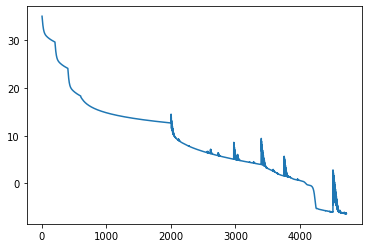

In [253]:
all_steps = np.linspace(1,len(history),len(history))
plt.figure()
plt.plot(all_steps,all_losses_log)
plt.show()

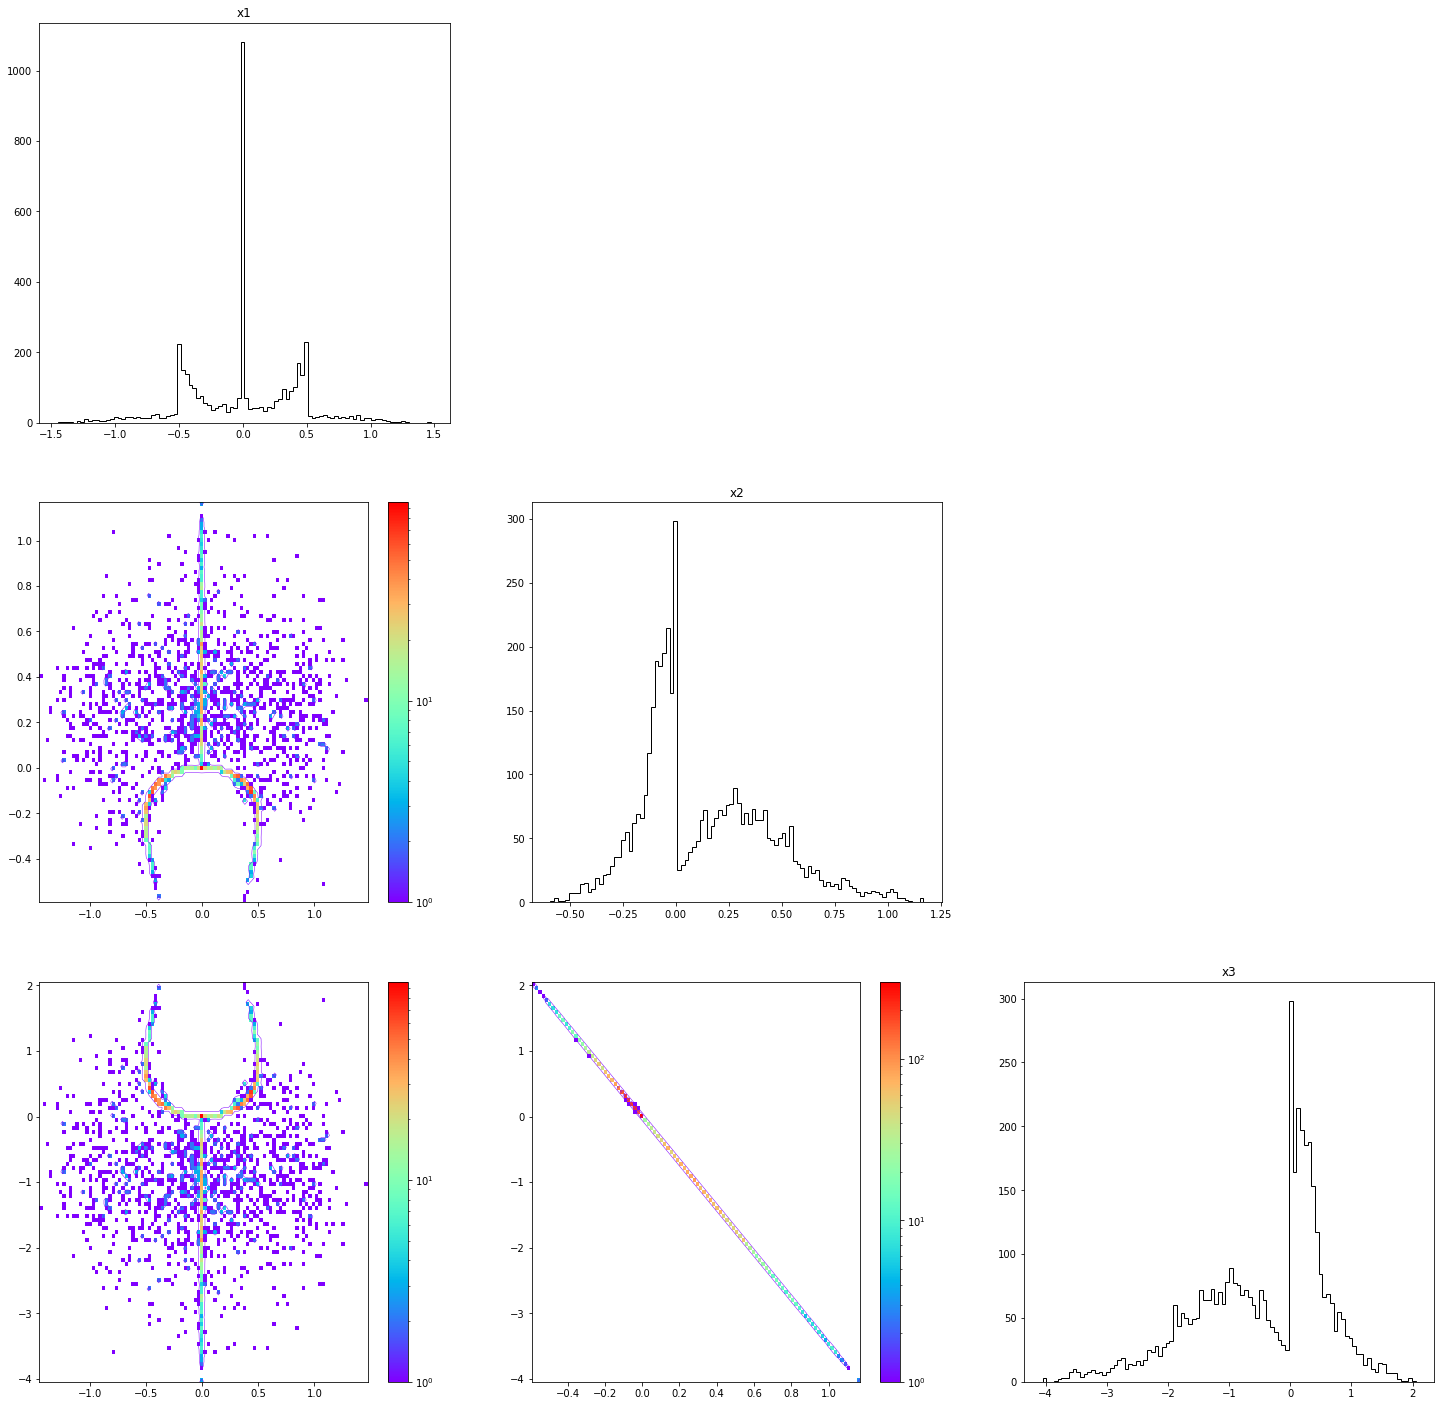

In [254]:
triangular_plot(list_with_update_le10mn)

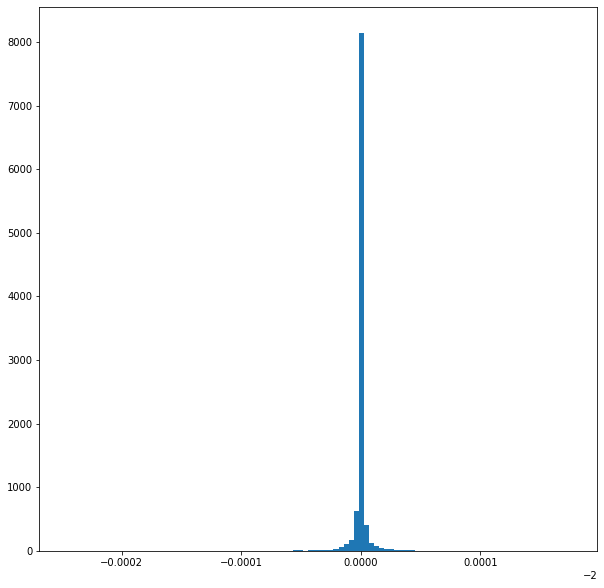

In [250]:
plt.figure(figsize=(10,10))
plt.hist(V13(x13).numpy(), 100)
plt.show()

In [ ]:
# compute what are the different slopes in the data
triangular_plot_slopes(x13,save='Triangular_plot_13d_slopes.png')

In [21]:
np.save('x_v13d_x1x3x7x9_260924',x13)

In [22]:
np.save('losses_v13d_x1x3x7x9_260924',all_losses)

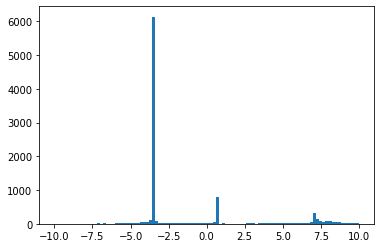

In [39]:
plt.figure()
data=x13.numpy()[:,3]/x13.numpy()[:,2]
histo=plt.hist(np.extract(np.abs(data)<10,data),100)
plt.show()

-3.5930855

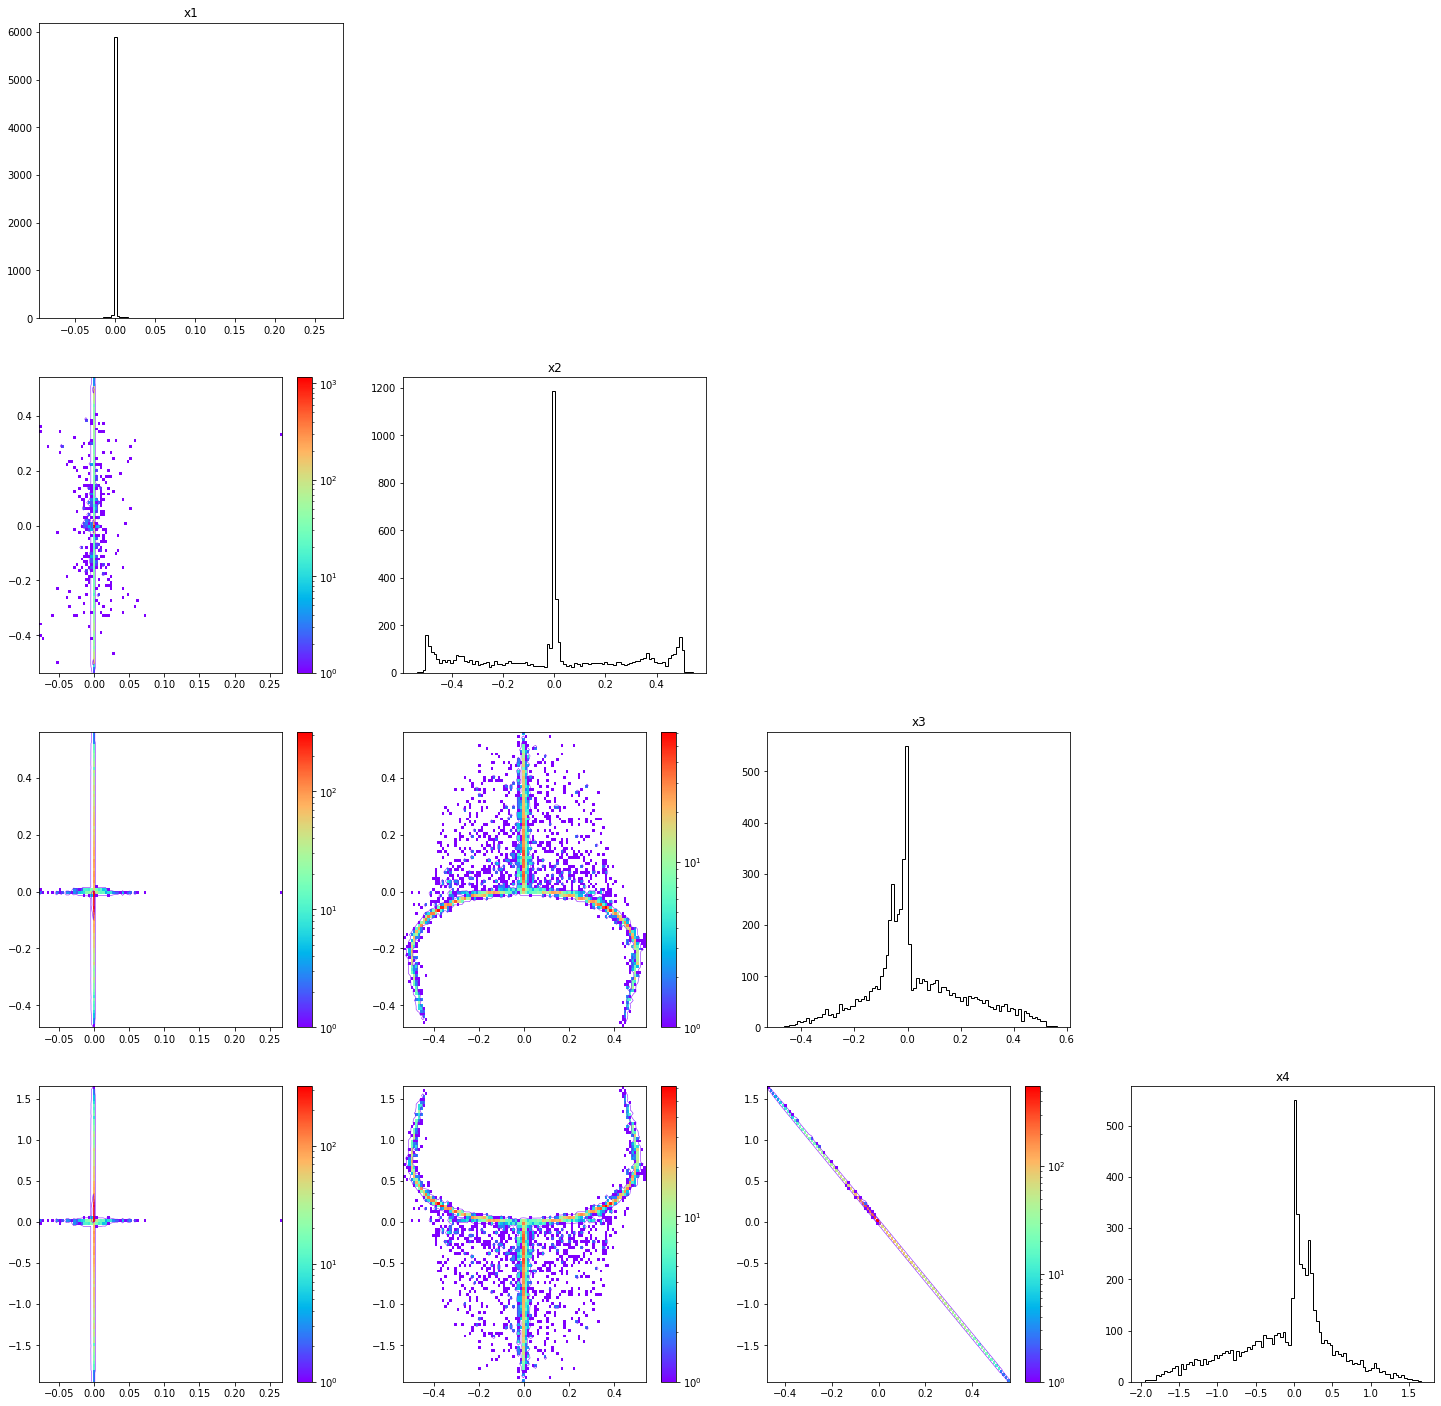

In [55]:
mask_0=is_on_axis(x13.numpy(),(2,3),histo[1][np.argmax(histo[0])],0.2)
points=np.transpose(np.array([np.extract(mask_0,x13[:,0].numpy()),np.extract(mask_0,x13[:,1].numpy()),np.extract(mask_0,x13[:,2].numpy()),np.extract(mask_0,x13[:,3].numpy())]))
triangular_plot(points)
